# 1. Extracting and merging temperature pairs in eICU2, eICU, MIMIC III, and MIMIC IV:

# Defines and Imports

In [236]:
# replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [237]:
# -3, -1.1
# -5, -3.1
# -9, -5.1
# -13, -9.1
# -21, -13.1
# -29, -21.1
# -36, -29.1
# -48, -36.1

In [238]:
# install necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
import missingno as msno

import numpy as np
import warnings
warnings.filterwarnings("ignore")

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [239]:
# variables to create temperature pairs
temp_pairs_vars = [
    'patientunitstayid',
    'nursingchartoffset',
    'Temp_C',
    'Temp_F'
]
temp_pairs_vars_mimic = [
    'stay_id',
    'Temp_C',
    'Temp_F'
]

# base date to create temperature pairs using the intial year for eICU2
base_date = pd.Timestamp('2019-01-01')
# base date to create temperature pairs using the intial year for eICU
base_date_eicu = pd.Timestamp('2014-01-01')
# columns to keep when merging for temperature pairs
eicu2_cols = [
    'patientunitstayid',
    'datetime_charted',
    'Temp_C',
    'nursingchartoffset'
]
eicu_cols = [
    'patientunitstayid',
    'datetime_charted',
    'Temp_C',
    'nursingchartoffset'
]
mimiciv_cols = [
    'stay_id',
    'subject_id',
    'hadm_id',
    'Temp_C',
    'charttime'
]

# temperature location mappings
temperature_location_mappings = {}
# dictionary mappings to identify correct temperature location recorded
temperature_location_mappings['eicu'] = {
    'temporal': [
        'Temporal', 'te,poral', 'teemporal', 'tem', 'tem[oral', 'tem[poral', 'temoporal', 'temoporol',
        'temopral', 'temoral', 'temp', 'temp  art', 'temp art', 'temp artery', 'temp at',
        'temp, art', 'temp.', 'tempa rt',
        'tempart', 'temperal',
        'temple', 'tempm art', 'tempoal', 'tempoarl', 'tempoeral', 'tempoiral', 'tempooral', 'tempor',
        'tempora', 'tempora;', 'temporak', 'temporal', 'temporal ', 'temporal  artery', 'temporal art',
        'temporal artery', 'temporal artery scan', 'temporal scan', 'temporal,', 'temporalf', 'temporarl',
        'temporol', 'temporral', 'temporsl', 'tempota', 'tempral', 'temprl', 'temproal', 'temproral',
        'tenporal', 'termporal', 'tewmporal', 'tmp', 'tmporal', '.ta', 'ta', 'forehead', ' temporal',
        'tymporal'
    ],
    'oral': [
        'Oral', 'o', 'o.', 'oal', 'oarl', 'olral', 'or', 'or ', 'or36.6al', 'ora', 'ora;', 'orak', 'oral',
        'oral ', 'oral/axillary', 'oral3.', 'oral49', 'orala', 'orall', 'orally', 'orl', 'orla', 'orsl',
        'otal'
    ],
    'core': [
        'Core', 'core', 'pa catheter', 'esophageal', 'esophageal probe', 'temperature sensing urinary catheter',
        'intravascular (swan)', 'core urinary catheter', 'bladder', 'eso', 'core temperature', 'bladr', 'foley ',
        'gastric tube, oral', 'bldr', 'foley', 'f.', 'foley', 'bldr', 'esoph', 'catheter', 'pa cath',
        'core central line', '.swan', 'esophageal ', 'pa', 'intravascular', 'swan', 'swan ganz', 'esophogeal',
        'esphageal', 'core ', 'foley temp'
    ],
    'rectal': [
        'rc', 'rctal', 're', 'rec', 'rec ', 'rec.', 'recatl', 'recrtal', 'rect', 'recta', 'recta;', 'rectaal',
        'rectal', 'rectal ', 'rectal  probe', 'rectal temp probe and foley temp probe', 'rectal;', 'rectall',
        'rectally', 'rectoal', 'rectsl', 'r', 'r.', '.rec'
    ],
    'other': [
        'axillary', 'axilla', 'ax', 'axllry', 'axi', 'axl', 'ax ', 'axilalry', 'axillaru', 'axilary'
    ],
    'tympanic': [
        'tympanic', 'tym', 'tymp', 'tempanic'
    ]
}

# make sure ethinicty is formatted the same
ethincity_replacements = {
    None: "Unknown",
    "African American": "Black",
    "Black/African American": "Black",
    "Native American": "American Indian / Alaska Native",
    "Indigenous/Native": "American Indian / Alaska Native",
    "Other/Unknown": "Unknown",
    "Hispanic": "Hispanic OR Latino",
    "Asian": "Asian",
}

# Pairs

In [240]:
# ex key eicu2 -> points to eicu2 dataframe
pairs = {}

## MIMIC-IV

In [241]:
%%bigquery mimiciv_temperature --project spring-carving-271217

Select *
FROM (
  SELECT subject_id,
         hadm_id,
         stay_id,
         charttime,
         di2.label,
         value
  FROM `physionet-data.mimiciv_icu.chartevents` ce
  LEFT JOIN `physionet-data.mimiciv_icu.d_items` di2 ON di2.itemid = ce.itemid
  WHERE ce.itemid IN (
      SELECT itemid
      FROM `physionet-data.mimiciv_icu.d_items` di
      WHERE (
          (linksto = 'chartevents')
          and
          di.category in ('Respiratory', 'Routine Vital Signs')
          and
          di.label in (
              'Temperature Celsius', 'Temperature Fahrenheit', 'Temperature Site'
              )
          )
    )

  )
  PIVOT (
    ANY_VALUE(value)
    FOR label IN (
            'Temperature Celsius', 'Temperature Fahrenheit', 'Temperature Site'
      )

  )
ORDER BY subject_id ASC, hadm_id ASC, charttime ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [242]:
display(mimiciv_temperature.head(2))

subject_id   hadm_id   stay_id           charttime Temperature Celsius  \
0    10000032  29079034  39553978 2180-07-23 14:00:00                None   
1    10000032  29079034  39553978 2180-07-23 17:00:00                None   

  Temperature Fahrenheit Temperature Site  
0                   98.7             Oral  
1                   98.7             Oral

### Data Cleaning

In [243]:
mimiciv_temperature['Temperature Site'] = mimiciv_temperature['Temperature Site'].str.lower()
mimiciv_temperature.rename(columns={'Temperature Fahrenheit': 'Temp_F', 'Temperature Celsius': 'Temp_C'}, inplace=True)
mimiciv_temperature[temp_pairs_vars_mimic] = mimiciv_temperature[temp_pairs_vars_mimic].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
mimiciv_temperature["Temp_C"] = round(mimiciv_temperature["Temp_C"], 1)
mimiciv_temperature["Temp_F"] = round(mimiciv_temperature["Temp_F"], 1)

### Drop NA Values in Temperature but Convert When Possible

In [244]:
# if Temp_F is missing but Temp_C is not convert to Temp_F using Temp_C and vice versa
mimiciv_temperature.loc[mimiciv_temperature['Temp_F'].isna() & mimiciv_temperature['Temp_C'].notna(), 'Temp_F'] = round(mimiciv_temperature['Temp_C'] * 9/5 + 32, 1)
mimiciv_temperature.loc[mimiciv_temperature['Temp_C'].isna() & mimiciv_temperature['Temp_F'].notna(), 'Temp_C'] = round((mimiciv_temperature['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
mimiciv_cleaned = mimiciv_temperature.dropna(subset=['Temp_C'])
# filter rows where 'Temp_C' is within the range [30, 45]
mimiciv_cleaned = mimiciv_cleaned[(mimiciv_cleaned['Temp_C'] >= 30) & (mimiciv_cleaned['Temp_C'] <= 45)]
print(
    'unique subjects with temperatures: ',
    len(mimiciv_cleaned['stay_id'].unique().tolist())
)

unique subjects with temperatures:  72485


### Make Temporal-Core Temperature Pairs

In [245]:
# filter and prepare the temporal temperature data
mimiciv_temp_temporal = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "temporal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'charttime': 'charttime_temporal'
}).sort_values(by=[
    'charttime_temporal'
]).copy()

# drop rows with null values
mimiciv_temp_temporal = mimiciv_temp_temporal.dropna().copy()

# filter and prepare the core temperature data
mimiciv_temp_core = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "esophogeal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'Temp_C_core',
    'charttime': 'charttime_core'
}).sort_values(by=[
    'charttime_core',
]).copy()

# drop rows with null values
mimiciv_temp_core = mimiciv_temp_core.loc[mimiciv_temp_core.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
mimiciv_merged_core = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_core,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_core.columns if '_todrop' in col]
mimiciv_merged_core.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_core_final = mimiciv_merged_core.loc[
    mimiciv_merged_core['Temp_C_core'].notnull(),
    :
]


In [246]:
mimiciv_merged_core_final

stay_id  subject_id   hadm_id  Temp_C_temporal  charttime_temporal  \
486    32303877    15795343  26631591             34.9 2112-03-13 01:00:00   
1213   35600501    15958770  24895093             37.0 2114-05-12 09:00:00   
1472   39781184    10835819  27759377             37.6 2115-02-03 10:36:00   
1510   31433523    18891541  26185304             35.3 2115-04-05 23:29:00   
2283   36137359    13191989  28038618             36.2 2116-12-12 11:15:00   
...         ...         ...       ...              ...                 ...   
35309  30980315    15276880  24782337             35.9 2187-05-19 19:00:00   
35527  38199253    14025287  20892830             36.8 2187-10-13 09:00:00   
36612  39702640    18253389  22631445             36.2 2189-05-24 16:00:00   
36620  39702640    18253389  22631445             36.5 2189-05-26 22:00:00   
36927  33559297    14065959  28133128             36.0 2190-02-06 13:00:00   

       Temp_C_core      charttime_core  
486           33.5 2112-03-13 00:00:00  
1213          36.9 2114-05-12 08:00:00  
1472          37.7 2115-02-03 11:22:00  
1510          33.5 2115-04-05 23:36:00  
2283          34.3 2116-12-12 11:00:00  
...            ...                 ...  
35309         36.0 2187-05-19 20:00:00  
35527         36.7 2187-10-13 08:00:00  
36612         35.4 2189-05-24 16:06:00  
36620         35.1 2189-05-26 21:00:00  
36927         36.1 2190-02-06 12:00:00  

[102 rows x 7 columns]

### Make Temporal-Rectal Temperature Pairs

In [247]:
# filter and prepare the temporal temperature data
mimiciv_temp_temporal = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "temporal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'charttime': 'charttime_temporal'
}).sort_values(by=[
    'charttime_temporal'
]).copy()

# drop rows with null values
mimiciv_temp_temporal = mimiciv_temp_temporal.dropna().copy()

# filter and prepare the rectal temperature data
mimiciv_temp_rectal = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "rectal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'Temp_C_rectal',
    'charttime': 'charttime_rectal'
}).sort_values(by=[
    'charttime_rectal',
]).copy()

# drop rows with null values
mimiciv_temp_rectal = mimiciv_temp_rectal.loc[mimiciv_temp_rectal.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
mimiciv_merged_rectal = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_rectal,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_rectal.columns if '_todrop' in col]
mimiciv_merged_rectal.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_rectal_final = mimiciv_merged_rectal.loc[
    mimiciv_merged_rectal['Temp_C_rectal'].notnull(),
    :
]

In [248]:
mimiciv_merged_rectal_final

stay_id  subject_id   hadm_id  Temp_C_temporal  charttime_temporal  \
1219   32414218    15029036  22383141             37.3 2114-05-13 13:00:00   
1454   33372982    13558101  26061249             36.3 2115-01-19 07:13:00   
2283   36137359    13191989  28038618             36.2 2116-12-12 11:15:00   
2284   36137359    13191989  28038618             36.2 2116-12-12 11:30:00   
2285   36137359    13191989  28038618             36.1 2116-12-12 11:45:00   
...         ...         ...       ...              ...                 ...   
36603  38168681    11137816  29365016             36.3 2189-05-20 13:00:00   
36831  39359062    17503991  29604798             36.1 2189-10-20 18:00:00   
37323  33884450    11106524  25055482             35.7 2191-06-05 13:00:00   
37324  33884450    11106524  25055482             35.9 2191-06-05 16:00:00   
37942  34364600    13192224  25595875             37.4 2194-04-15 00:00:00   

       Temp_C_rectal    charttime_rectal  
1219            36.2 2114-05-13 13:45:00  
1454            35.5 2115-01-19 08:00:00  
2283            34.6 2116-12-12 12:00:00  
2284            34.6 2116-12-12 12:00:00  
2285            34.6 2116-12-12 12:00:00  
...              ...                 ...  
36603           35.6 2189-05-20 13:30:00  
36831           35.3 2189-10-20 19:00:00  
37323           34.4 2191-06-05 14:00:00  
37324           34.4 2191-06-05 17:00:00  
37942           36.3 2194-04-14 23:00:00  

[91 rows x 7 columns]

### Make Temporal-Oral Temperature Pairs

In [249]:
# filter and prepare the temporal temperature data
mimiciv_temp_temporal = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "temporal",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'charttime': 'charttime_temporal'
}).sort_values(by=[
    'charttime_temporal'
]).copy()

# drop rows with null values
mimiciv_temp_temporal = mimiciv_temp_temporal.dropna().copy()

# filter and prepare the rectal temperature data
mimiciv_temp_oral = mimiciv_cleaned.loc[
    mimiciv_cleaned['Temperature Site'] == "oral",
    mimiciv_cols
].rename(columns={
    'Temp_C': 'Temp_C_oral',
    'charttime': 'charttime_oral'
}).sort_values(by=[
    'charttime_oral',
]).copy()

# drop rows with null values
mimiciv_temp_oral = mimiciv_temp_oral.loc[mimiciv_temp_oral.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
mimiciv_merged_oral = pd.merge_asof(
    left=mimiciv_temp_temporal,
    right=mimiciv_temp_oral,
    left_by='stay_id',
    right_by='stay_id',
    left_on='charttime_temporal',
    right_on='charttime_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# drop the _todrop columns
columns_to_drop = [col for col in mimiciv_merged_oral.columns if '_todrop' in col]
mimiciv_merged_oral.drop(columns=columns_to_drop, inplace=True)

# filter to keep only rows with non-null core temperatures
mimiciv_merged_oral_final = mimiciv_merged_oral.loc[
    mimiciv_merged_oral['Temp_C_oral'].notnull(),
    :
]

In [250]:
mimiciv_merged_oral_final

stay_id  subject_id   hadm_id  Temp_C_temporal  charttime_temporal  \
40     31495997    14756995  28143436             37.2 2110-05-17 17:00:00   
43     33302469    14344243  29899161             37.2 2110-05-23 08:00:00   
67     31153814    18069293  26126274             37.4 2110-07-31 16:00:00   
78     39242904    18069293  23136125             35.9 2110-08-29 05:30:00   
79     39242904    18069293  23136125             36.5 2110-08-29 05:55:00   
...         ...         ...       ...              ...                 ...   
39609  39731216    17055995  26588116             37.1 2205-08-06 16:00:00   
39643  32380994    14454179  28167243             36.8 2206-03-01 19:00:00   
39654  32380994    14454179  28167243             36.8 2206-03-02 06:00:00   
39655  32380994    14454179  28167243             36.3 2206-03-02 19:00:00   
39700  37996986    19508874  28498140             35.9 2207-05-03 06:00:00   

       Temp_C_oral      charttime_oral  
40            37.5 2110-05-17 16:00:00  
43            36.9 2110-05-23 07:00:00  
67            37.3 2110-07-31 15:00:00  
78            36.6 2110-08-29 05:54:00  
79            36.6 2110-08-29 05:54:00  
...            ...                 ...  
39609         36.6 2205-08-06 17:00:00  
39643         36.8 2206-03-01 18:00:00  
39654         37.1 2206-03-02 07:00:00  
39655         37.2 2206-03-02 18:00:00  
39700         36.4 2207-05-03 07:00:00  

[1359 rows x 7 columns]

### Combine All Pairs into a Unified Dataframe

In [251]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
mimiciv_merged_rectal_final = mimiciv_merged_rectal_final.rename(columns={'Temp_C_rectal': 'Temp_C_reference', 'charttime_rectal': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal' })
mimiciv_merged_rectal_final["pair"] = "temporal-rectal"
mimiciv_merged_core_final = mimiciv_merged_core_final.rename(columns={'Temp_C_core': 'Temp_C_reference', 'charttime_core': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal'})
mimiciv_merged_core_final["pair"] = "temporal-core"
mimiciv_merged_oral_final = mimiciv_merged_oral_final.rename(columns={'Temp_C_oral': 'Temp_C_reference', 'charttime_oral': 'datetime_charted_reference', 'charttime_temporal': 'datetime_charted_temporal'})
mimiciv_merged_oral_final["pair"] = "temporal-oral"

In [252]:
# concat dataframes into one unified dataframe
mimiciv_merged_final = pd.concat([mimiciv_merged_rectal_final, mimiciv_merged_core_final, mimiciv_merged_oral_final], axis=0)
# make a new column for the latest offset, which refers to the latest temperature taken
mimiciv_merged_final['later_datetime'] = mimiciv_merged_final[['datetime_charted_temporal', 'datetime_charted_reference']].max(axis=1)

In [253]:
mimiciv_merged_final.pair.value_counts()

pair
temporal-oral      1359
temporal-core       102
temporal-rectal      91
Name: count, dtype: int64

In [254]:
# mimiciv_merged_final["check"] = abs(mimiciv_merged_final["datetime_charted_reference"] - mimiciv_merged_final["datetime_charted_temporal"])
# mimiciv_merged_final["check"].mean()

In [255]:
display(mimiciv_merged_final)

stay_id  subject_id   hadm_id  Temp_C_temporal  \
1219   32414218    15029036  22383141             37.3   
1454   33372982    13558101  26061249             36.3   
2283   36137359    13191989  28038618             36.2   
2284   36137359    13191989  28038618             36.2   
2285   36137359    13191989  28038618             36.1   
...         ...         ...       ...              ...   
39609  39731216    17055995  26588116             37.1   
39643  32380994    14454179  28167243             36.8   
39654  32380994    14454179  28167243             36.8   
39655  32380994    14454179  28167243             36.3   
39700  37996986    19508874  28498140             35.9   

      datetime_charted_temporal  Temp_C_reference datetime_charted_reference  \
1219        2114-05-13 13:00:00              36.2        2114-05-13 13:45:00   
1454        2115-01-19 07:13:00              35.5        2115-01-19 08:00:00   
2283        2116-12-12 11:15:00              34.6        2116-12-12 12:00:00   
2284        2116-12-12 11:30:00              34.6        2116-12-12 12:00:00   
2285        2116-12-12 11:45:00              34.6        2116-12-12 12:00:00   
...                         ...               ...                        ...   
39609       2205-08-06 16:00:00              36.6        2205-08-06 17:00:00   
39643       2206-03-01 19:00:00              36.8        2206-03-01 18:00:00   
39654       2206-03-02 06:00:00              37.1        2206-03-02 07:00:00   
39655       2206-03-02 19:00:00              37.2        2206-03-02 18:00:00   
39700       2207-05-03 06:00:00              36.4        2207-05-03 07:00:00   

                  pair      later_datetime  
1219   temporal-rectal 2114-05-13 13:45:00  
1454   temporal-rectal 2115-01-19 08:00:00  
2283   temporal-rectal 2116-12-12 12:00:00  
2284   temporal-rectal 2116-12-12 12:00:00  
2285   temporal-rectal 2116-12-12 12:00:00  
...                ...                 ...  
39609    temporal-oral 2205-08-06 17:00:00  
39643    temporal-oral 2206-03-01 19:00:00  
39654    temporal-oral 2206-03-02 07:00:00  
39655    temporal-oral 2206-03-02 19:00:00  
39700    temporal-oral 2207-05-03 07:00:00  

[1552 rows x 9 columns]

## eICU1

In [256]:
# pull temperatures from nurse chart table
%%bigquery eicu_temperature --project spring-carving-271217

SELECT *
FROM (
  SELECT
    patientunitstayid,
    nursingchartoffset,
    nursingchartcelltypevallabel,
    nursingchartcelltypevalname,
    nursingchartvalue
  FROM
    `physionet-data.eicu_crd.nursecharting`
  WHERE
    nursingchartcelltypevallabel IN ('Temperature')
)
PIVOT (
  ANY_VALUE(nursingchartvalue)
  FOR nursingchartcelltypevalname IN (
    'Temperature (C)' AS Temp_C,
    'Temperature (F)' AS Temp_F,
    'Temperature Location' AS Temp_Location
  )
)
WHERE
  Temp_Location IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [257]:
display(eicu_temperature.head(2))

patientunitstayid  nursingchartoffset nursingchartcelltypevallabel Temp_C  \
0            1353273              -12993                  Temperature   35.6   
1            3071835                5030                  Temperature     39   

  Temp_F Temp_Location  
0   96.1             4  
1  102.2        rectal

### Data Cleaning

In [258]:
eicu_temperature['Temp_Location'] = eicu_temperature['Temp_Location'].str.lower()
# conform to the correct data type
eicu_temperature[temp_pairs_vars] = eicu_temperature[temp_pairs_vars].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
eicu_temperature["Temp_C"] = round(eicu_temperature["Temp_C"], 1)
eicu_temperature["Temp_F"] = round(eicu_temperature["Temp_F"], 1)

### Drop NA Values in Temperature but Convert When Possible

In [259]:
# if Temp_F is missing but Temp_C is not convert to Temp_F using Temp_C and vice versa
eicu_temperature.loc[eicu_temperature['Temp_F'].isna() & eicu_temperature['Temp_C'].notna(), 'Temp_F'] = round(eicu_temperature['Temp_C'] * 9/5 + 32, 1)
eicu_temperature.loc[eicu_temperature['Temp_C'].isna() & eicu_temperature['Temp_F'].notna(), 'Temp_C'] = round((eicu_temperature['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
eicu_cleaned = eicu_temperature.dropna(subset=['Temp_C'])
# filter rows where 'Temp_C' is within the range [30, 45]
eicu_cleaned = eicu_cleaned[(eicu_cleaned['Temp_C'] >= 30) & (eicu_cleaned['Temp_C'] <= 45)]
print(
    'unique subjects with temperatures: ',
    len(eicu_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  148758


### Confrom Temperature Locations to Proper Format

In [260]:
# apply mappings to conform them to proper temperature locations
# add an indicator to show what has been mapped
for key in temperature_location_mappings['eicu']:
  eicu_cleaned.loc[
    eicu_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_' + key] = 1
  eicu_cleaned.loc[
    eicu_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_mapped' ] = key
# drop any observations that haven't been mapped
eicu_cleaned = eicu_cleaned.dropna(subset=['Temp_Location_mapped'])
print(
    'unique subjects with temperatures: ',
    len(eicu_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  145727


### Convert nursingchartoffset into a Datetime Format

In [261]:
eicu_cleaned['datetime_charted'] = base_date_eicu + pd.to_timedelta(eicu_cleaned['nursingchartoffset'], unit='m')

### Make Temporal-Core Temperature Pairs

In [262]:
# revisit this; just clarify pairs

# filter and prepare the temporal temperature data
eicu_temp_temporal = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_temporal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu_temp_temporal = eicu_temp_temporal.loc[eicu_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the core temperature data
eicu_temp_core = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_core'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'Temp_C_core',
    'datetime_charted': 'datetime_charted_core',
    'nursingchartoffset': 'nursingchartoffset_core'
}).sort_values(by=[
    'datetime_charted_core',
]).copy()

# drop rows with null values
eicu_temp_core = eicu_temp_core.loc[eicu_temp_core.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu_merged_core = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu_merged_core_final = eicu_merged_core.loc[
    eicu_merged_core['Temp_C_core'].notnull(),
    :
]

### Make Temporal-Rectal Temperature Pairs

In [263]:
# filter and prepare the temporal temperature data
eicu_temp_temporal = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_temporal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu_temp_temporal = eicu_temp_temporal.loc[eicu_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the rectal temperature data
eicu_temp_rectal = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_rectal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'Temp_C_rectal',
    'datetime_charted': 'datetime_charted_rectal',
    'nursingchartoffset': 'nursingchartoffset_rectal'
}).sort_values(by=[
    'datetime_charted_rectal',
]).copy()

# drop rows with null values
eicu_temp_rectal = eicu_temp_rectal.loc[eicu_temp_rectal.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu_merged_rectal = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null temperatures
eicu_merged_rectal_final = eicu_merged_rectal.loc[
    eicu_merged_rectal['Temp_C_rectal'].notnull(),
    :
]

### Make Temporal-Oral Temperature Pairs

In [264]:
# filter and prepare the temporal temperature data
eicu_temp_temporal = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_temporal'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu_temp_temporal = eicu_temp_temporal.loc[eicu_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the oral temperature data
eicu_temp_oral = eicu_cleaned.loc[
    eicu_cleaned['Temp_Location_oral'] == 1,
    eicu_cols
].rename(columns={
    'Temp_C': 'Temp_C_oral',
    'datetime_charted': 'datetime_charted_oral',
    'nursingchartoffset': 'nursingchartoffset_oral'
}).sort_values(by=[
    'datetime_charted_oral',
]).copy()

# drop rows with null values
eicu_temp_oral = eicu_temp_oral.loc[eicu_temp_oral.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu_merged_oral = pd.merge_asof(
    left=eicu_temp_temporal,
    right=eicu_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null temperatures
eicu_merged_oral_final = eicu_merged_oral.loc[
    eicu_merged_oral['Temp_C_oral'].notnull(),
    :
]

In [265]:
eicu_merged_oral_final

Output hidden; open in https://colab.research.google.com to view.

### Combine All Pairs into a Unified Dataframe

In [266]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
eicu_merged_rectal_final = eicu_merged_rectal_final.rename(columns={'Temp_C_rectal': 'Temp_C_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu_merged_rectal_final["pair"] = "temporal-rectal"
eicu_merged_core_final = eicu_merged_core_final.rename(columns={'Temp_C_core': 'Temp_C_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu_merged_core_final["pair"] = "temporal-core"
eicu_merged_oral_final = eicu_merged_oral_final.rename(columns={'Temp_C_oral': 'Temp_C_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu_merged_oral_final["pair"] = "temporal-oral"

In [267]:
# concat dataframes into one unified dataframe
eicu_merged_final = pd.concat([eicu_merged_rectal_final, eicu_merged_core_final, eicu_merged_oral_final], axis=0)
# make a new column for the latest offset, which refers to the latest temperature taken
eicu_merged_final['later_datetime'] = eicu_merged_final[['datetime_charted_temporal', 'datetime_charted_reference']].max(axis=1)
eicu_merged_final['later_offset'] = eicu_merged_final.apply(
    lambda row: row['nursingchartoffset'] if row['later_datetime'] == row['datetime_charted_temporal'] else row['nursingchartoffset_reference'],
    axis=1
)

In [268]:
display(eicu_merged_final)

Output hidden; open in https://colab.research.google.com to view.

## eICU2

In [269]:
# pull temperatures from nurse chart table
%%bigquery eicu2_temperature --project aiwonglab
SELECT * from
(

SELECT patientunitstayid,
nursingchartoffset,
nursingchartcelltypevallabel,
nursingchartcelltypevalname,
nursingchartvalue
FROM `aiwonglab.eicu_crd_ii_v0_1_0.nursecharting`
WHERE nursingchartcelltypevallabel in ('Temperature')

)

PIVOT (
  ANY_VALUE(nursingchartvalue)
  FOR nursingchartcelltypevalname IN (
            'Temperature (C)' as Temp_C,
            'Temperature (F)' as Temp_F,
            'Temperature Location' as Temp_Location
      )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [270]:
display(eicu2_temperature.head(2))

patientunitstayid  nursingchartoffset nursingchartcelltypevallabel Temp_C  \
0            6931329                7452                  Temperature   35.4   
1            6987873                  10                  Temperature   35.1   

  Temp_F Temp_Location  
0   95.7         groin  
1   95.2         groin

### Data Cleaning

In [271]:
# remove "removed: not cleared" in Temp_C, Temp_F, and Temp_Location
eicu2_temperature = eicu2_temperature[eicu2_temperature['Temp_C'] != "removed: not cleared"]
eicu2_temperature = eicu2_temperature[eicu2_temperature['Temp_F'] != "removed: not cleared"]
eicu2_cleaned = eicu2_temperature[eicu2_temperature['Temp_Location'] != "removed: not cleared"]
print(
    'unique subjects with temperatures: ',
    len(eicu2_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  189663


In [272]:
# lower strings to make it easier to match temperature location
eicu2_cleaned['Temp_Location'] = eicu2_cleaned['Temp_Location'].str.lower()
# conform to the correct data type
eicu2_cleaned[temp_pairs_vars] = eicu2_cleaned[temp_pairs_vars].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
eicu2_cleaned["Temp_C"] = round(eicu2_cleaned["Temp_C"], 1)
eicu2_cleaned["Temp_F"] = round(eicu2_cleaned["Temp_F"], 1)

### Drop NA Values in Temperature but Convert When Possible

In [273]:
# if Temp_F is missing but Temp_C is not convert to Temp_F using Temp_C and vice versa
eicu2_cleaned.loc[eicu2_cleaned['Temp_F'].isna() & eicu2_cleaned['Temp_C'].notna(), 'Temp_F'] = round(eicu2_cleaned['Temp_C'] * 9/5 + 32, 1)
eicu2_cleaned.loc[eicu2_cleaned['Temp_C'].isna() & eicu2_cleaned['Temp_F'].notna(), 'Temp_C'] = round((eicu2_cleaned['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
eicu2_cleaned = eicu2_cleaned.dropna(subset=['Temp_C'])
# filter rows where 'Temp_C' is within the range [30, 45]
eicu2_cleaned = eicu2_cleaned[(eicu2_cleaned['Temp_C'] >= 30) & (eicu2_cleaned['Temp_C'] <= 45)]

### Confrom Temperature Locations to Proper Format

In [274]:
# apply mappings to conform them to proper temperature locations
# add an indicator to show what has been mapped
for key in temperature_location_mappings['eicu']:
  eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_' + key] = 1
  eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_mapped' ] = key
# drop any observations that haven't been mapped
eicu2_cleaned = eicu2_cleaned.dropna(subset=['Temp_Location_mapped'])
print(
    'unique subjects with temperatures: ',
    len(eicu2_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  102162


### Convert `nursingchartoffset` into a Datetime Format

In [275]:
eicu2_cleaned['datetime_charted'] = base_date + pd.to_timedelta(eicu2_cleaned['nursingchartoffset'], unit='m')

### Make Temporal-Core Temperature Pairs

In [276]:
# revisit this; just clarify pairs

# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the core temperature data
eicu2_temp_core = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_core'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_core',
    'datetime_charted': 'datetime_charted_core',
    'nursingchartoffset': 'nursingchartoffset_core'
}).sort_values(by=[
    'datetime_charted_core',
]).copy()

# drop rows with null values
eicu2_temp_core = eicu2_temp_core.loc[eicu2_temp_core.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu2_merged_core = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_core_final = eicu2_merged_core.loc[
    eicu2_merged_core['Temp_C_core'].notnull(),
    :
]


In [277]:
display(eicu2_merged_core_final)

patientunitstayid datetime_charted_temporal  Temp_C_temporal  \
572               6849137       2018-11-10 23:17:00             36.6   
634               6207701       2018-11-13 11:32:00             36.5   
754               6849137       2018-11-16 19:47:00             36.4   
917               6855108       2018-11-20 19:39:00             36.5   
1041              6855108       2018-11-24 04:39:00             36.8   
...                   ...                       ...              ...   
130157            6152569       2019-02-04 16:06:00             38.5   
130372            7158916       2019-02-06 14:48:00             36.3   
130457            7158916       2019-02-07 07:48:00             35.3   
130534            6242389       2019-02-08 02:43:00             36.0   
130904            6149889       2019-02-11 20:07:00             38.0   

        nursingchartoffset datetime_charted_core  Temp_C_core  \
572                 -73483   2018-11-11 00:17:00         36.9   
634                 -69868   2018-11-13 11:43:00         36.6   
754                 -65053   2018-11-16 19:03:00         36.8   
917                 -59301   2018-11-20 19:54:00         36.9   
1041                -54441   2018-11-24 03:39:00         37.2   
...                    ...                   ...          ...   
130157               49926   2019-02-04 15:06:00         38.5   
130372               52728   2019-02-06 13:48:00         35.4   
130457               53748   2019-02-07 06:48:00         36.2   
130534               54883   2019-02-08 03:43:00         35.9   
130904               60247   2019-02-11 19:07:00         37.7   

        nursingchartoffset_core  
572                      -73423  
634                      -69857  
754                      -65097  
917                      -59286  
1041                     -54501  
...                         ...  
130157                    49866  
130372                    52668  
130457                    53688  
130534                    54943  
130904                    60187  

[420 rows x 7 columns]

### Make Temporal-Rectal Temperature Pairs


In [278]:
# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the rectal temperature data
eicu2_temp_rectal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_rectal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_rectal',
    'datetime_charted': 'datetime_charted_rectal',
    'nursingchartoffset': 'nursingchartoffset_rectal'
}).sort_values(by=[
    'datetime_charted_rectal',
]).copy()

# drop rows with null values
eicu2_temp_rectal = eicu2_temp_rectal.loc[eicu2_temp_rectal.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu2_merged_rectal = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_rectal_final = eicu2_merged_rectal.loc[
    eicu2_merged_rectal['Temp_C_rectal'].notnull(),
    :
]

In [279]:
display(eicu2_merged_rectal_final)

patientunitstayid datetime_charted_temporal  Temp_C_temporal  \
3241              6061282       2018-12-22 18:00:00             37.2   
4646              6292863       2018-12-26 11:17:00             35.9   
5204              7159060       2018-12-27 09:06:00             38.0   
5213              7159060       2018-12-27 09:29:00             38.0   
5818              6275365       2018-12-28 04:25:00             35.8   
...                   ...                       ...              ...   
119891            6057922       2019-01-14 05:02:00             37.2   
121847            6143912       2019-01-15 21:09:00             37.9   
124688            6955232       2019-01-18 23:55:00             38.0   
124747            6955232       2019-01-19 01:55:00             38.2   
124940            7000865       2019-01-19 08:20:00             37.3   

        nursingchartoffset datetime_charted_rectal  Temp_C_rectal  \
3241                -13320     2018-12-22 18:53:00           38.6   
4646                 -7963     2018-12-26 11:54:00           34.6   
5204                 -6654     2018-12-27 10:06:00           38.1   
5213                 -6631     2018-12-27 10:06:00           38.1   
5818                 -5495     2018-12-28 03:52:00           35.5   
...                    ...                     ...            ...   
119891               19022     2019-01-14 04:02:00           37.2   
121847               21429     2019-01-15 20:44:00           38.0   
124688               25915     2019-01-19 00:55:00           38.9   
124747               26035     2019-01-19 00:55:00           38.9   
124940               26420     2019-01-19 09:16:00           37.5   

        nursingchartoffset_rectal  
3241                       -13267  
4646                        -7926  
5204                        -6594  
5213                        -6594  
5818                        -5528  
...                           ...  
119891                      18962  
121847                      21404  
124688                      25975  
124747                      25975  
124940                      26476  

[132 rows x 7 columns]

### Make Temporal-Oral Temperature Pairs


In [280]:
# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the oral temperature data
eicu2_temp_oral = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_oral'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_oral',
    'datetime_charted': 'datetime_charted_oral',
    'nursingchartoffset': 'nursingchartoffset_oral'
}).sort_values(by=[
    'datetime_charted_oral',
]).copy()

# drop rows with null values
eicu2_temp_oral = eicu2_temp_oral.loc[eicu2_temp_oral.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu2_merged_oral = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null core temperatures
eicu2_merged_oral_final = eicu2_merged_oral.loc[
    eicu2_merged_oral['Temp_C_oral'].notnull(),
    :
]

In [281]:
display(eicu2_merged_oral_final)

patientunitstayid datetime_charted_temporal  Temp_C_temporal  \
163               7171238       2018-10-17 18:32:00             36.9   
245               7158046       2018-10-25 10:25:00             36.6   
272               7160022       2018-10-27 04:35:00             36.4   
316               7160022       2018-10-29 22:26:00             36.3   
331               7160022       2018-10-30 17:54:00             36.2   
...                   ...                       ...              ...   
131710            6151617       2019-04-03 00:58:00             36.7   
131734            6151617       2019-04-04 21:35:00             36.3   
131754            6151617       2019-04-06 16:27:00             35.3   
131794            6151617       2019-04-12 01:07:00             36.5   
131968            6854001       2019-05-11 13:31:00             36.7   

        nursingchartoffset datetime_charted_oral  Temp_C_oral  \
163                -108328   2018-10-17 19:32:00         36.7   
245                 -97295   2018-10-25 10:58:00         36.8   
272                 -94765   2018-10-27 04:46:00         36.8   
316                 -90814   2018-10-29 22:50:00         36.8   
331                 -89646   2018-10-30 17:36:00         37.0   
...                    ...                   ...          ...   
131710              132538   2019-04-03 01:23:00         36.5   
131734              135215   2019-04-04 22:19:00         36.9   
131754              137787   2019-04-06 15:57:00         36.6   
131794              145507   2019-04-12 02:06:00         36.9   
131968              188011   2019-05-11 14:31:00         36.2   

        nursingchartoffset_oral  
163                     -108268  
245                      -97262  
272                      -94754  
316                      -90790  
331                      -89664  
...                         ...  
131710                   132563  
131734                   135259  
131754                   137757  
131794                   145566  
131968                   188071  

[3840 rows x 7 columns]

### Combine All Pairs into a Unified Dataframe

In [282]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
eicu2_merged_rectal_final = eicu2_merged_rectal_final.rename(columns={'Temp_C_rectal': 'Temp_C_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu2_merged_rectal_final["pair"] = "temporal-rectal"
eicu2_merged_core_final = eicu2_merged_core_final.rename(columns={'Temp_C_core': 'Temp_C_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu2_merged_core_final["pair"] = "temporal-core"
eicu2_merged_oral_final = eicu2_merged_oral_final.rename(columns={'Temp_C_oral': 'Temp_C_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu2_merged_oral_final["pair"] = "temporal-oral"

In [283]:
# concat dataframes into one unified dataframe
eicu2_merged_final = pd.concat([eicu2_merged_rectal_final, eicu2_merged_core_final, eicu2_merged_oral_final], axis=0)
# make a new column for the latest offset, which refers to the latest temperature taken
eicu2_merged_final['later_datetime'] = eicu2_merged_final[['datetime_charted_temporal', 'datetime_charted_reference']].max(axis=1)
eicu2_merged_final['later_offset'] = eicu2_merged_final.apply(
    lambda row: row['nursingchartoffset'] if row['later_datetime'] == row['datetime_charted_temporal'] else row['nursingchartoffset_reference'],
    axis=1
)

In [284]:
display(eicu2_merged_final)

Output hidden; open in https://colab.research.google.com to view.

## Upload

In [285]:
import pandas_gbq
pairs["eicu2"] = eicu2_merged_final
pairs["eicu"] = eicu_merged_final
pairs["mimiciv"] = mimiciv_merged_final


project_id = "spring-carving-271217"
dataset_id = "test"

def create_table_id(project_id, dataset_id, tab_id):

  return f"{project_id}.{dataset_id}.{tab_id}"

for t_name, t_df in pairs.items():

  table_id = create_table_id(project_id, dataset_id, t_name)
  t_df.to_gbq(table_id, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 674.98it/s]


# Add Time-Series Characteristics

In [286]:
# grabs google sheet
def get_vars_df(sheet_id, gid):

  return pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}')

In [287]:
# subquery to pull table

# add a maxmimum timestamp to use as the offset
# redo calculation
def create_subquery(pairs_table,
                    temperature_time,
                    var_type,
                    var_name,
                    var_new_name,
                    var_window_low_hr,
                    var_window_upper_hr,
                    var_source_table,
                    var_foreign_key,
                    var_timestamp):


    if temperature_time == "later_datetime":
      time_diff = f"TIMESTAMP_DIFF(CAST(table.{var_timestamp} AS TIMESTAMP), CAST(pairs.{temperature_time} AS TIMESTAMP), MINUTE)"
    # print(var_name)
    elif temperature_time == "later_offset":
      time_diff = f"table.{var_timestamp} - pairs.{temperature_time} "

    return f"""
    {var_type}_{var_name} AS (
      SELECT * FROM (
        SELECT
          pairs.{var_foreign_key},
          {var_name},
          pairs.{temperature_time},
          {time_diff} AS delta_{var_type}_{var_new_name},
          ROW_NUMBER() OVER(PARTITION BY pairs.{var_foreign_key}, pairs.{temperature_time}
                            ORDER BY ABS({time_diff}) ASC) AS seq
        FROM `{pairs_table}` pairs
        LEFT JOIN `{var_source_table}` AS table
        ON table.{var_foreign_key} = pairs.{var_foreign_key}
        AND {var_name} IS NOT NULL
        AND {time_diff} BETWEEN {var_window_low_hr} * 60 AND {var_window_upper_hr} * 60
      )
      WHERE seq = 1
    )
    """

In [288]:
def create_complete_query(pairs_table, vars_df, temporal_time):

  subquery_list = []

  # Iterate over each row in df
  for index, row in vars_df.iterrows():

      subquery = create_subquery(pairs_table,
                                 temporal_time,
                                 row['var_type'],
                                 row['var_name'],
                                 row['var_new_name'],
                                 row['var_window_low_hr'],
                                 row['var_window_upper_hr'],
                                 row['var_source_table'],
                                 row['var_foreign_key'],
                                 row['var_timestamp'])
      subquery_list.append(subquery)

  # Now you have your subqueries, join them into one string
  subquery_string = ",\n\n".join(subquery_list)
  final_query = f"""
  WITH
  {subquery_string}
  SELECT
      pairs.*,
      {" , ".join([f"{row.var_type}_{row.var_name}.delta_{row.var_type}_{row.var_new_name}, {row.var_type}_{row.var_name}.{row.var_name} AS {row.var_type}_{row.var_new_name}" for index, row in vars_df.iterrows()])}
  FROM `{pairs_table}` pairs
  {" ".join([f"LEFT JOIN {row.var_type}_{row.var_name} ON {row.var_type}_{row.var_name}.{row.var_foreign_key} = pairs.{row.var_foreign_key} AND {row.var_type}_{row.var_name}.{temporal_time} = pairs.{temporal_time}" for index, row in vars_df.iterrows()])}
  """
  return final_query

## MIMIC-IV

In [289]:
temporal_time = "later_datetime"
pairs_table = "spring-carving-271217.test.mimiciv"

sheet_id = "1SOWmaaq_FR5kkMXYnM1-6V7SR8vd0PPPuhvSmSpB_jA"
gid = "0"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, temporal_time)
# print(query)
client = bigquery.Client(project='spring-carving-271217')
mimiciv_df = client.query(query).to_dataframe()

In [290]:
display(mimiciv_df)

stay_id  subject_id   hadm_id  Temp_C_temporal  \
0     34044852    18152377  24517143             35.2   
1     39548461    15422928  25572886             36.0   
2     30820371    12953330  23898756             34.6   
3     32557628    10059406  23005038             36.7   
4     33121922    19970466  26846190             35.5   
...        ...         ...       ...              ...   
1547  38039429    13696494  20396589             38.2   
1548  38039429    13696494  20396589             37.3   
1549  38039429    13696494  20396589             38.1   
1550  38039429    13696494  20396589             37.6   
1551  38039429    13696494  20396589             37.6   

     datetime_charted_temporal  Temp_C_reference datetime_charted_reference  \
0    2140-05-18 02:23:00+00:00              34.0  2140-05-18 02:18:00+00:00   
1    2136-05-25 08:00:00+00:00              34.0  2136-05-25 07:00:00+00:00   
2    2157-08-19 21:00:00+00:00              34.0  2157-08-19 20:00:00+00:00   
3    2122-01-05 15:00:00+00:00              36.0  2122-01-05 14:00:00+00:00   
4    2151-05-04 20:00:00+00:00              36.0  2151-05-04 21:00:00+00:00   
...                        ...               ...                        ...   
1547 2194-07-07 13:00:00+00:00              37.2  2194-07-07 12:00:00+00:00   
1548 2194-07-08 19:00:00+00:00              37.7  2194-07-08 18:00:00+00:00   
1549 2194-07-08 15:00:00+00:00              38.1  2194-07-08 14:00:00+00:00   
1550 2194-07-08 12:00:00+00:00              37.6  2194-07-08 13:00:00+00:00   
1551 2194-07-10 05:00:00+00:00              37.6  2194-07-10 04:00:00+00:00   

                 pair            later_datetime  delta_vitals_heart_rate_min  \
0     temporal-rectal 2140-05-18 02:23:00+00:00                          -23   
1       temporal-oral 2136-05-25 08:00:00+00:00                            0   
2       temporal-oral 2157-08-19 21:00:00+00:00                            0   
3       temporal-core 2122-01-05 15:00:00+00:00                            0   
4       temporal-core 2151-05-04 21:00:00+00:00                            0   
...               ...                       ...                          ...   
1547    temporal-oral 2194-07-07 13:00:00+00:00                            0   
1548    temporal-oral 2194-07-08 19:00:00+00:00                            0   
1549    temporal-oral 2194-07-08 15:00:00+00:00                            0   
1550    temporal-oral 2194-07-08 13:00:00+00:00                            0   
1551    temporal-oral 2194-07-10 05:00:00+00:00                            0   

      ...  delta_sofa_future_coagulation_24hr  sofa_future_coagulation_24hr  \
0     ...                                1537                             0   
1     ...                                1500                             0   
2     ...                                1500                             0   
3     ...                                1500                             0   
4     ...                                1500                             2   
...   ...                                 ...                           ...   
1547  ...                                1500                             0   
1548  ...                                1500                             0   
1549  ...                                1500                             0   
1550  ...                                1500                             0   
1551  ...                                1500                             0   

      delta_sofa_future_liver_24hr  sofa_future_liver_24hr  \
0                             1537                       0   
1                             1500                       0   
2                             1500                       0   
3                             1500                       0   
4                             1500                       0   
...                            ...                     ...   
1547                         

## eiCU1

In [291]:
temporal_time = "later_offset"
pairs_table = "spring-carving-271217.test.eicu"

sheet_id = "1SOWmaaq_FR5kkMXYnM1-6V7SR8vd0PPPuhvSmSpB_jA"
gid = "326954316"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, temporal_time)
# print(query)
client = bigquery.Client(project='spring-carving-271217')
eicu_df = client.query(query).to_dataframe()

In [292]:
display(eicu_df)

patientunitstayid datetime_charted_temporal  Temp_C_temporal  \
0               3221970 2013-12-31 23:17:00+00:00             36.2   
1               3221970 2013-12-31 23:32:00+00:00             36.4   
2               2058844 2014-01-01 21:12:00+00:00             35.3   
3               2058844 2014-01-01 21:24:00+00:00             35.3   
4               2058844 2014-01-01 21:39:00+00:00             34.8   
...                 ...                       ...              ...   
7332            2679548 2013-12-31 20:58:00+00:00             41.0   
7333            2407720 2014-01-01 06:46:00+00:00             40.7   
7334            3142611 2014-01-01 10:31:00+00:00             38.7   
7335            3201188 2014-01-04 21:36:00+00:00             38.8   
7336            2018962 2014-01-01 16:22:00+00:00             39.3   

      nursingchartoffset datetime_charted_reference  Temp_C_reference  \
0                    -43  2014-01-01 00:17:00+00:00              34.0   
1                    -28  2014-01-01 00:17:00+00:00              34.0   
2                   1272  2014-01-01 21:54:00+00:00              34.0   
3                   1284  2014-01-01 21:54:00+00:00              34.0   
4                   1299  2014-01-01 21:54:00+00:00              34.0   
...                  ...                        ...               ...   
7332                -182  2013-12-31 21:56:00+00:00              39.6   
7333                 406  2014-01-01 06:56:00+00:00              39.6   
7334                 631  2014-01-01 11:31:00+00:00              39.6   
7335                5616  2014-01-04 20:36:00+00:00              39.6   
7336                 982  2014-01-01 16:23:00+00:00              39.6   

      nursingchartoffset_reference             pair            later_datetime  \
0                               17    temporal-oral 2014-01-01 00:17:00+00:00   
1                               17    temporal-oral 2014-01-01 00:17:00+00:00   
2                             1314  temporal-rectal 2014-01-01 21:54:00+00:00   
3                             1314  temporal-rectal 2014-01-01 21:54:00+00:00   
4                             1314  temporal-rectal 2014-01-01 21:54:00+00:00   
...                            ...              ...                       ...   
7332                          -124    temporal-oral 2013-12-31 21:56:00+00:00   
7333                           416  temporal-rectal 2014-01-01 06:56:00+00:00   
7334                           691    temporal-oral 2014-01-01 11:31:00+00:00   
7335                          5556    temporal-oral 2014-01-04 21:36:00+00:00   
7336                           983    temporal-oral 2014-01-01 16:23:00+00:00   

      later_offset  ...  delta_sofa_future_coagulation_24hr  \
0               17  ...                                <NA>   
1               17  ...                                <NA>   
2             1314  ...                                <NA>   
3             1314  ...                                <NA>   
4             1314  ...                                <NA>   
...            ...  ...                                 ...   
7332          -124  ...                                1504   
7333           416  ...                                <NA>   
7334           691  ...                                <NA>   
7335          5616  ...                                1524   
7336           983  ...                                <NA>   

      sofa_future_coagulation_24hr  delta_sofa_future_liver_24hr  \
0                             <NA>                          <NA>   
1                             <NA>                          <NA>   
2                             <NA>                          <NA>   
3                             <NA>                          <NA>   
4                             <NA>                          <NA>   
...                            ...                           ...   
7332                             1                          1504   
7333          

## eICU2

In [293]:
temporal_time = "later_offset"
pairs_table = "spring-carving-271217.test.eicu2"

sheet_id = "1SOWmaaq_FR5kkMXYnM1-6V7SR8vd0PPPuhvSmSpB_jA"
gid = "891660135"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, temporal_time)
# print(query)
client = bigquery.Client(project='spring-carving-271217')
eicu2_df = client.query(query).to_dataframe()

In [294]:
display(eicu2_df)

patientunitstayid datetime_charted_temporal  Temp_C_temporal  \
0               6152253 2018-12-31 23:37:00+00:00             36.1   
1               6152253 2019-01-01 00:09:00+00:00             36.1   
2               6155913 2019-01-02 15:51:00+00:00             36.1   
3               6155222 2018-12-31 23:20:00+00:00             36.7   
4               6155222 2019-01-01 00:04:00+00:00             36.7   
...                 ...                       ...              ...   
4387            6303616 2019-01-01 13:58:00+00:00             37.2   
4388            7162684 2018-12-31 23:03:00+00:00             36.3   
4389            6158664 2018-12-31 23:54:00+00:00             37.7   
4390            6152808 2019-01-08 12:37:00+00:00             37.3   
4391            6893210 2019-01-06 04:50:00+00:00             37.7   

      nursingchartoffset datetime_charted_reference  Temp_C_reference  \
0                    -23  2019-01-01 00:07:00+00:00              34.0   
1                      9  2019-01-01 00:07:00+00:00              34.0   
2                   2391  2019-01-02 14:51:00+00:00              34.0   
3                    -40  2019-01-01 00:20:00+00:00              34.0   
4                      4  2019-01-01 00:20:00+00:00              34.0   
...                  ...                        ...               ...   
4387                 838  2019-01-01 14:22:00+00:00              37.6   
4388                 -57  2019-01-01 00:03:00+00:00              37.6   
4389                  -6  2019-01-01 00:03:00+00:00              37.6   
4390               10837  2019-01-08 12:10:00+00:00              37.6   
4391                7490  2019-01-06 03:50:00+00:00              39.6   

      nursingchartoffset_reference             pair            later_datetime  \
0                                7    temporal-core 2019-01-01 00:07:00+00:00   
1                                7    temporal-core 2019-01-01 00:09:00+00:00   
2                             2331    temporal-oral 2019-01-02 15:51:00+00:00   
3                               20    temporal-core 2019-01-01 00:20:00+00:00   
4                               20    temporal-core 2019-01-01 00:20:00+00:00   
...                            ...              ...                       ...   
4387                           862    temporal-oral 2019-01-01 14:22:00+00:00   
4388                             3    temporal-oral 2019-01-01 00:03:00+00:00   
4389                             3    temporal-oral 2019-01-01 00:03:00+00:00   
4390                         10810    temporal-oral 2019-01-08 12:37:00+00:00   
4391                          7430  temporal-rectal 2019-01-06 04:50:00+00:00   

      later_offset  ...  delta_sofa_future_coagulation_24hr  \
0                7  ...                                <NA>   
1                9  ...                                <NA>   
2             2391  ...                                1509   
3               20  ...                                1540   
4               20  ...                                1540   
...            ...  ...                                 ...   
4387           862  ...                                <NA>   
4388             3  ...                                1557   
4389             3  ...                                <NA>   
4390         10837  ...                                <NA>   
4391          7490  ...                                <NA>   

     sofa_future_coagulation_24hr  delta_sofa_future_liver_24hr  \
0                            <NA>                          <NA>   
1                            <NA>                          <NA>   
2                               0                          1509   
3                               3                          1540   
4                               3                          1540   
...                           ...                           ...   
4387                         <NA>                          <NA>   
4388                  

# Add Patient Characteristics

## MIMIC-IV

In [295]:
%%bigquery mimic_iv_pat --project aiwonglab

SELECT DISTINCT
    icu.subject_id,
    icu.hadm_id AS hospital_admission_id,
    icu.stay_id AS icustay_id,
    "mimic_iv" AS source_db,
    9999 AS hospitalid,
    ">= 500" AS numbedscategory,
    TRUE AS teachingstatus,
    "Northeast" AS region,
    CASE
        WHEN icu.admission_age > 90 THEN 90
        ELSE icu.admission_age
    END AS admission_age,
    CASE
        WHEN icu.gender = "F" THEN 1
        ELSE 0
    END AS sex_female,
    weight.weight_admit AS weight_admission,
    height.height AS height_admission,
    weight.weight_admit / (POWER(height.height / 100, 2)) AS BMI_admission,
    icu.admittime AS datetime_hospital_admit,
    icu.dischtime AS datetime_hospital_discharge,
    icu.icu_intime AS datetime_icu_admit,
    icu.icu_outtime AS datetime_icu_discharge,
    icu.los_hospital,
    icu.los_icu AS los_ICU,
    "Charlson" AS comorbidity_score_name,
    charlson.charlson_comorbidity_index AS comorbidity_score_value,
    ad.hospital_expire_flag AS in_hospital_mortality,
    icu.race AS race_ethnicity

-- ICU stays
FROM `physionet-data.mimiciv_derived.icustay_detail` AS icu

-- Age
LEFT JOIN `physionet-data.mimiciv_hosp.patients` AS pat
ON icu.subject_id = pat.subject_id

-- Weight
LEFT JOIN `physionet-data.mimiciv_derived.first_day_weight` AS weight
ON icu.stay_id = weight.stay_id

-- Height
LEFT JOIN `physionet-data.mimiciv_derived.first_day_height` AS height
ON icu.stay_id = height.stay_id

-- Admissions
LEFT JOIN `physionet-data.mimiciv_hosp.admissions` AS ad
ON icu.hadm_id = ad.hadm_id

-- Charlson
LEFT JOIN `physionet-data.mimiciv_derived.charlson` AS charlson
ON icu.hadm_id = charlson.hadm_id

Query is running:   0%|          |

Downloading:   0%|          |

In [296]:
sheets_id = "1Hv_sOd0--6TPYiB3Crjdn_JrIhIazXXJc05mL4GefOU"
gid = "1877090341"

mimic_iv_map = get_vars_df(sheets_id, gid)

mapping_series = mimic_iv_map.set_index('original')['mapping']

# Map the 'race_ethnicity' column in the 'mimic_iv_pat' DataFrame
mimic_iv_pat['race_ethnicity'] = mimic_iv_pat['race_ethnicity'].map(mapping_series)

## eICU1

In [297]:
# Grab patient info from derived ICU stays table and patient table
%%bigquery eicu_patv2 --project aiwonglab

SELECT DISTINCT
    icu.uniquepid AS subject_id,
    icu.patienthealthsystemstayid AS hospital_admission_id,
    icu.patientunitstayid AS icustay_id,
    'eicu2' AS source_db,
    icu.hospitalid,
    hosp.numbedscategory,
    hosp.teachingstatus,
    hosp.region,
    CASE
        WHEN icu.age = '> 89' THEN CAST(90 AS STRING)
        ELSE icu.age
    END AS admission_age,
    CASE
        WHEN pat.gender = "Female" THEN 1
        ELSE 0
    END AS sex_female,
    icu.admissionweight AS weight_admission,
    icu.admissionheight AS height_admission,
    CASE
        WHEN icu.admissionheight > 0 THEN icu.admissionweight / (POWER(icu.admissionheight / 100, 2))
        ELSE NULL
    END AS BMI_admission,
    icu.hospitaladmitoffset AS offset_hospital_admit,
    icu.hospitaldischargeoffset AS offset_hospital_discharge,
    icu.unitadmitoffset AS offset_icu_admit,
    icu.unitdischargeoffset AS offset_icu_discharge,
    (icu.hospitaldischargeoffset - icu.hospitaladmitoffset) / 60 AS los_hospital,
    icu.icu_los_hours AS los_ICU,
    icu.hosp_mort AS in_hospital_mortality,
    pat.ethnicity AS race_ethnicity,
    pat.hospitalDischargeStatus AS clinical_outcome,
    pat.unitType AS icu_unit,
    "Charlson" AS comorbidity_score_name,
    cci.charlson_score AS comorbidity_score_value
FROM `physionet-data.eicu_crd_derived.icustay_detail` AS icu

LEFT JOIN `physionet-data.eicu_crd.patient` AS pat
ON pat.patienthealthsystemstayid = icu.patienthealthsystemstayid

LEFT JOIN `physionet-data.eicu_crd.hospital` AS hosp
ON pat.hospitalid = hosp.hospitalid

LEFT JOIN `spring-carving-271217.eicu.cci` AS cci
ON cci.patientunitstayid = icu.patientunitstayid

Query is running:   0%|          |

Downloading:   0%|          |

In [298]:
eicu_patv2["race_ethnicity"] = eicu_patv2["race_ethnicity"].replace(ethincity_replacements, inplace=False)
eicu_patv2["race_ethnicity"].unique()
# convert offsets to timestamp
eicu_patv2['offset_hospital_admit'] = base_date_eicu + pd.to_timedelta(eicu_patv2['offset_hospital_admit'], unit='m')
eicu_patv2['offset_hospital_discharge'] = base_date_eicu + pd.to_timedelta(eicu_patv2['offset_hospital_discharge'], unit='m')
eicu_patv2['offset_icu_admit'] = base_date_eicu + pd.to_timedelta(eicu_patv2['offset_icu_admit'], unit='m')
eicu_patv2['offset_icu_discharge'] = base_date_eicu + pd.to_timedelta(eicu_patv2['offset_icu_discharge'], unit='m')

eicu_patv2 = eicu_patv2.rename(columns={
    'offset_hospital_admit': 'datetime_hospital_admit',
    'offset_hospital_discharge': 'datetime_hospital_discharge',
    'offset_icu_admit': 'datetime_icu_admit',
    'offset_icu_discharge': 'datetime_icu_discharge',
})

## eICU2

In [299]:
# grab patient info from dervied icu stays table and patient table
%%bigquery eicu2_patv2 --project aiwonglab

# note that uniquepid is not "unique" as different patients hold the same uniquepid
SELECT DISTINCT
    icu.uniquepid AS subject_id,
    icu.patienthealthsystemstayid AS hospital_admission_id,
    icu.patientunitstayid AS icustay_id,
    'eicu2' AS source_db,
    icu.hospitalid,
    hosp.numbedscategory,
    hosp.teachingstatus,
    hosp.region,
    CASE
        WHEN icu.age = '> 89' THEN CAST(90 AS STRING)
        ELSE icu.age
    END AS admission_age,
    CASE
        WHEN pat.gender = "Female" THEN 1
        ELSE 0
    END AS sex_female,
    icu.admissionweight AS weight_admission,
    icu.admissionheight AS height_admission,
    CASE
        WHEN icu.admissionheight > 0 THEN icu.admissionweight / (POWER(icu.admissionheight/100, 2))
        ELSE NULL
    END AS BMI_admission,
    icu.hospitaladmitoffset AS offset_hospital_admit,
    icu.hospitaldischargeoffset AS offset_hospital_discharge,
    icu.unitadmitoffset AS offset_icu_admit,
    icu.unitdischargeoffset AS offset_icu_discharge,
    (icu.hospitaldischargeoffset - icu.hospitaladmitoffset)/60 AS los_hospital,
    icu.icu_los_hours AS los_ICU,
    icu.hosp_mort AS in_hospital_mortality,
    pat.ethnicity AS race_ethnicity,
    pat.hospitalDischargeStatus AS clinical_outcome,
    pat.unitType AS icu_unit,
    "Charlson" AS comorbidity_score_name,
    cci.charlson_score AS comorbidity_score_value
FROM `eicu_crd_ii_v0_1_0_derived.icustay_detail` AS icu
LEFT JOIN `eicu_crd_ii_v0_1_0.patient` AS pat
  ON pat.patienthealthsystemstayid = icu.patienthealthsystemstayid
LEFT JOIN `eicu_crd_ii_v0_1_0.hospital` AS hosp
  ON pat.hospitalid = hosp.hospitalid
LEFT JOIN `spring-carving-271217.test.cci` AS cci
  ON cci.patientunitstayid = icu.patientunitstayid

Query is running:   0%|          |

Downloading:   0%|          |

In [300]:
# clean race_ethnicity variable before merging
eicu2_patv2["race_ethnicity"] = eicu2_patv2["race_ethnicity"].replace(ethincity_replacements, inplace=False)
eicu2_patv2["race_ethnicity"].unique()
# convert offsets to timestamp
eicu2_patv2['offset_hospital_admit'] = base_date + pd.to_timedelta(eicu2_patv2['offset_hospital_admit'], unit='m')
eicu2_patv2['offset_hospital_discharge'] = base_date + pd.to_timedelta(eicu2_patv2['offset_hospital_discharge'], unit='m')
eicu2_patv2['offset_icu_admit'] = base_date + pd.to_timedelta(eicu2_patv2['offset_icu_admit'], unit='m')
eicu2_patv2['offset_icu_discharge'] = base_date + pd.to_timedelta(eicu2_patv2['offset_icu_discharge'], unit='m')

eicu2_patv2 = eicu2_patv2.rename(columns={
    'offset_hospital_admit': 'datetime_hospital_admit',
    'offset_hospital_discharge': 'datetime_hospital_discharge',
    'offset_icu_admit': 'datetime_icu_admit',
    'offset_icu_discharge': 'datetime_icu_discharge',
})

In [301]:
mimiciv_df = mimiciv_df.rename(columns={"stay_id": "icustay_id",
                                          "hadm_id": "hospital_admission_id"
                                    })

In [302]:
eicu_df = eicu_df.rename(columns={"uniquepid": "subject_id",
                                  "patienthealthsystemstayid": "hospital_admission_id",
                                  "patientunitstayid": "icustay_id"})

In [303]:
eicu2_df = eicu2_df.rename(columns={"uniquepid": "subject_id",
                                  "patienthealthsystemstayid": "hospital_admission_id",
                                  "patientunitstayid": "icustay_id"})

In [304]:
# rename vital window columns to have the same labels
mimiciv_df.columns = mimiciv_df.columns.str.replace(r'(delta_)?vitals_window\d+_tempc_window(\d+)', r'\1vitals_tempc_window\2', regex=True)
eicu_df.columns = eicu_df.columns.str.replace(r'(delta_)?vitals_window\d+_tempc_window(\d+)', r'\1vitals_tempc_window\2', regex=True)
eicu2_df.columns = eicu2_df.columns.str.replace(r'(delta_)?vitals_window\d+_tempc_window(\d+)', r'\1vitals_tempc_window\2', regex=True)

# Finalize

## Merge Horizontally

In [305]:
# double check this
filtered_eicu2_patv2 = eicu2_patv2.drop_duplicates(subset='icustay_id', keep='first')
filtered_eicu_patv2 = eicu_patv2.drop_duplicates(subset='icustay_id', keep='first')

mimiciv_final = mimic_iv_pat.merge(
                  mimiciv_df.drop(["subject_id"], axis=1),
                  on=['hospital_admission_id', 'icustay_id']
                    )

eicu_final = eicu_df.merge(
    filtered_eicu_patv2,
    left_on='icustay_id',
    right_on='icustay_id',
    how='left'
)

eicu2_final = eicu2_df.merge(
    filtered_eicu2_patv2,
    left_on='icustay_id',
    right_on='icustay_id',
    how='left'
)


In [306]:
display(mimiciv_final)

subject_id  hospital_admission_id  icustay_id source_db  hospitalid  \
0       15141808               29304956    35444993  mimic_iv        9999   
1       15141808               29304956    35444993  mimic_iv        9999   
2       11964641               25048257    30655528  mimic_iv        9999   
3       11964641               25048257    30655528  mimic_iv        9999   
4       11939778               21500970    31526970  mimic_iv        9999   
...          ...                    ...         ...       ...         ...   
1547    17176996               25317420    35102151  mimic_iv        9999   
1548    12502220               21737102    37565086  mimic_iv        9999   
1549    17362787               28378354    36903904  mimic_iv        9999   
1550    17362787               28378354    36903904  mimic_iv        9999   
1551    17362787               28378354    36903904  mimic_iv        9999   

     numbedscategory  teachingstatus     region  admission_age  sex_female  \
0             >= 500            True  Northeast             26           1   
1             >= 500            True  Northeast             26           1   
2             >= 500            True  Northeast             26           1   
3             >= 500            True  Northeast             26           1   
4             >= 500            True  Northeast             30           1   
...              ...             ...        ...            ...         ...   
1547          >= 500            True  Northeast             76           0   
1548          >= 500            True  Northeast             83           0   
1549          >= 500            True  Northeast             84           0   
1550          >= 500            True  Northeast             84           0   
1551          >= 500            True  Northeast             84           0   

      ...  delta_sofa_future_coagulation_24hr sofa_future_coagulation_24hr  \
0     ...                                <NA>                         <NA>   
1     ...                                <NA>                         <NA>   
2     ...                                <NA>                         <NA>   
3     ...                                <NA>                         <NA>   
4     ...                                1500                            0   
...   ...                                 ...                          ...   
1547  ...                                1530                            1   
1548  ...                                1500                            1   
1549  ...                                1500                            0   
1550  ...                                1515                            0   
1551  ...                                1500                            0   

      delta_sofa_future_liver_24hr sofa_future_liver_24hr  \
0                             <NA>                   <NA>   
1                             <NA>                   <NA>   
2                             <NA>                   <NA>   
3                             <NA>                   <NA>   
4                             1500                      2   
...                            ...                    ...   
1547                          1530                      0   
1548                          1500                      0   
1549                          1500                      0   
1550                          1515                      0   
1551                          1500                      0   

     delta_sofa_future_cardiovascular_24hr sofa_future_cardiovascular_24hr  \
0                                     <NA>                            <NA>   
1                                     <NA>                            <NA>   
2                                     <NA>                            <NA>   
3                                     <NA>                            <NA>   
4                                     1500                               4   
...   

In [307]:
display(eicu_final)

icustay_id datetime_charted_temporal  Temp_C_temporal  \
0        3221970 2013-12-31 23:17:00+00:00             36.2   
1        3221970 2013-12-31 23:32:00+00:00             36.4   
2        2058844 2014-01-01 21:12:00+00:00             35.3   
3        2058844 2014-01-01 21:24:00+00:00             35.3   
4        2058844 2014-01-01 21:39:00+00:00             34.8   
...          ...                       ...              ...   
7332     2679548 2013-12-31 20:58:00+00:00             41.0   
7333     2407720 2014-01-01 06:46:00+00:00             40.7   
7334     3142611 2014-01-01 10:31:00+00:00             38.7   
7335     3201188 2014-01-04 21:36:00+00:00             38.8   
7336     2018962 2014-01-01 16:22:00+00:00             39.3   

      nursingchartoffset datetime_charted_reference  Temp_C_reference  \
0                    -43  2014-01-01 00:17:00+00:00              34.0   
1                    -28  2014-01-01 00:17:00+00:00              34.0   
2                   1272  2014-01-01 21:54:00+00:00              34.0   
3                   1284  2014-01-01 21:54:00+00:00              34.0   
4                   1299  2014-01-01 21:54:00+00:00              34.0   
...                  ...                        ...               ...   
7332                -182  2013-12-31 21:56:00+00:00              39.6   
7333                 406  2014-01-01 06:56:00+00:00              39.6   
7334                 631  2014-01-01 11:31:00+00:00              39.6   
7335                5616  2014-01-04 20:36:00+00:00              39.6   
7336                 982  2014-01-01 16:23:00+00:00              39.6   

      nursingchartoffset_reference             pair            later_datetime  \
0                               17    temporal-oral 2014-01-01 00:17:00+00:00   
1                               17    temporal-oral 2014-01-01 00:17:00+00:00   
2                             1314  temporal-rectal 2014-01-01 21:54:00+00:00   
3                             1314  temporal-rectal 2014-01-01 21:54:00+00:00   
4                             1314  temporal-rectal 2014-01-01 21:54:00+00:00   
...                            ...              ...                       ...   
7332                          -124    temporal-oral 2013-12-31 21:56:00+00:00   
7333                           416  temporal-rectal 2014-01-01 06:56:00+00:00   
7334                           691    temporal-oral 2014-01-01 11:31:00+00:00   
7335                          5556    temporal-oral 2014-01-04 21:36:00+00:00   
7336                           983    temporal-oral 2014-01-01 16:23:00+00:00   

      later_offset  ...  datetime_icu_admit  datetime_icu_discharge  \
0               17  ...          2014-01-01     2014-01-01 12:08:00   
1               17  ...          2014-01-01     2014-01-01 12:08:00   
2             1314  ...          2014-01-01     2014-01-02 18:54:00   
3             1314  ...          2014-01-01     2014-01-02 18:54:00   
4             1314  ...          2014-01-01     2014-01-02 18:54:00   
...            ...  ...                 ...                     ...   
7332          -124  ...          2014-01-01     2014-01-04 01:40:00   
7333           416  ...          2014-01-01     2014-01-02 00:25:00   
7334           691  ...          2014-01-01     2014-01-01 22:11:00   
7335          5616  ...          2014-01-01     2014-01-20 14:52:00   
7336           983  ...          2014-01-01     2014-01-02 12:17:00   

      los_hospital  los_ICU  in_hospital_mortality  \
0       130.833333     12.0                      0   
1       130.833333     12.0                      0   
2        48.766667     43.0                      1   
3        48.766667     43.0                      1   
4        48.766667     43.0                      1   
...            ...      ...                    ...   
7332    306.583333     74.0                      0   
7333    103.766667     24.0                      0   
7334    273.100000     22.0                      0   
7335  

In [308]:
display(eicu2_final)

icustay_id datetime_charted_temporal  Temp_C_temporal  \
0        6152253 2018-12-31 23:37:00+00:00             36.1   
1        6152253 2019-01-01 00:09:00+00:00             36.1   
2        6155913 2019-01-02 15:51:00+00:00             36.1   
3        6155222 2018-12-31 23:20:00+00:00             36.7   
4        6155222 2019-01-01 00:04:00+00:00             36.7   
...          ...                       ...              ...   
4387     6303616 2019-01-01 13:58:00+00:00             37.2   
4388     7162684 2018-12-31 23:03:00+00:00             36.3   
4389     6158664 2018-12-31 23:54:00+00:00             37.7   
4390     6152808 2019-01-08 12:37:00+00:00             37.3   
4391     6893210 2019-01-06 04:50:00+00:00             37.7   

      nursingchartoffset datetime_charted_reference  Temp_C_reference  \
0                    -23  2019-01-01 00:07:00+00:00              34.0   
1                      9  2019-01-01 00:07:00+00:00              34.0   
2                   2391  2019-01-02 14:51:00+00:00              34.0   
3                    -40  2019-01-01 00:20:00+00:00              34.0   
4                      4  2019-01-01 00:20:00+00:00              34.0   
...                  ...                        ...               ...   
4387                 838  2019-01-01 14:22:00+00:00              37.6   
4388                 -57  2019-01-01 00:03:00+00:00              37.6   
4389                  -6  2019-01-01 00:03:00+00:00              37.6   
4390               10837  2019-01-08 12:10:00+00:00              37.6   
4391                7490  2019-01-06 03:50:00+00:00              39.6   

      nursingchartoffset_reference             pair            later_datetime  \
0                                7    temporal-core 2019-01-01 00:07:00+00:00   
1                                7    temporal-core 2019-01-01 00:09:00+00:00   
2                             2331    temporal-oral 2019-01-02 15:51:00+00:00   
3                               20    temporal-core 2019-01-01 00:20:00+00:00   
4                               20    temporal-core 2019-01-01 00:20:00+00:00   
...                            ...              ...                       ...   
4387                           862    temporal-oral 2019-01-01 14:22:00+00:00   
4388                             3    temporal-oral 2019-01-01 00:03:00+00:00   
4389                             3    temporal-oral 2019-01-01 00:03:00+00:00   
4390                         10810    temporal-oral 2019-01-08 12:37:00+00:00   
4391                          7430  temporal-rectal 2019-01-06 04:50:00+00:00   

      later_offset  ...  datetime_icu_admit datetime_icu_discharge  \
0                7  ...          2019-01-01    2019-01-01 11:32:00   
1                9  ...          2019-01-01    2019-01-01 11:32:00   
2             2391  ...          2019-01-01    2019-01-06 08:05:00   
3               20  ...          2019-01-01    2019-01-08 07:18:00   
4               20  ...          2019-01-01    2019-01-08 07:18:00   
...            ...  ...                 ...                    ...   
4387           862  ...          2019-01-01    2019-01-02 13:46:00   
4388             3  ...          2019-01-01    2019-01-09 10:49:00   
4389             3  ...          2019-01-01    2019-01-01 18:49:00   
4390         10837  ...          2019-01-01    2019-01-05 17:35:00   
4391          7490  ...          2019-01-01    2019-01-04 00:16:00   

      los_hospital los_ICU  in_hospital_mortality      race_ethnicity  \
0       231.466667    12.0                      0               Black   
1       231.466667    12.0                      0               Black   
2       146.033333   128.0                      1           Caucasian   
3       199.150000   175.0                      0           Caucasian   
4       199.150000   175.0                      0           Caucasian   
...            ...     ...                    ...                 ...   
4387    106.983333    38.0                     

<Axes: >

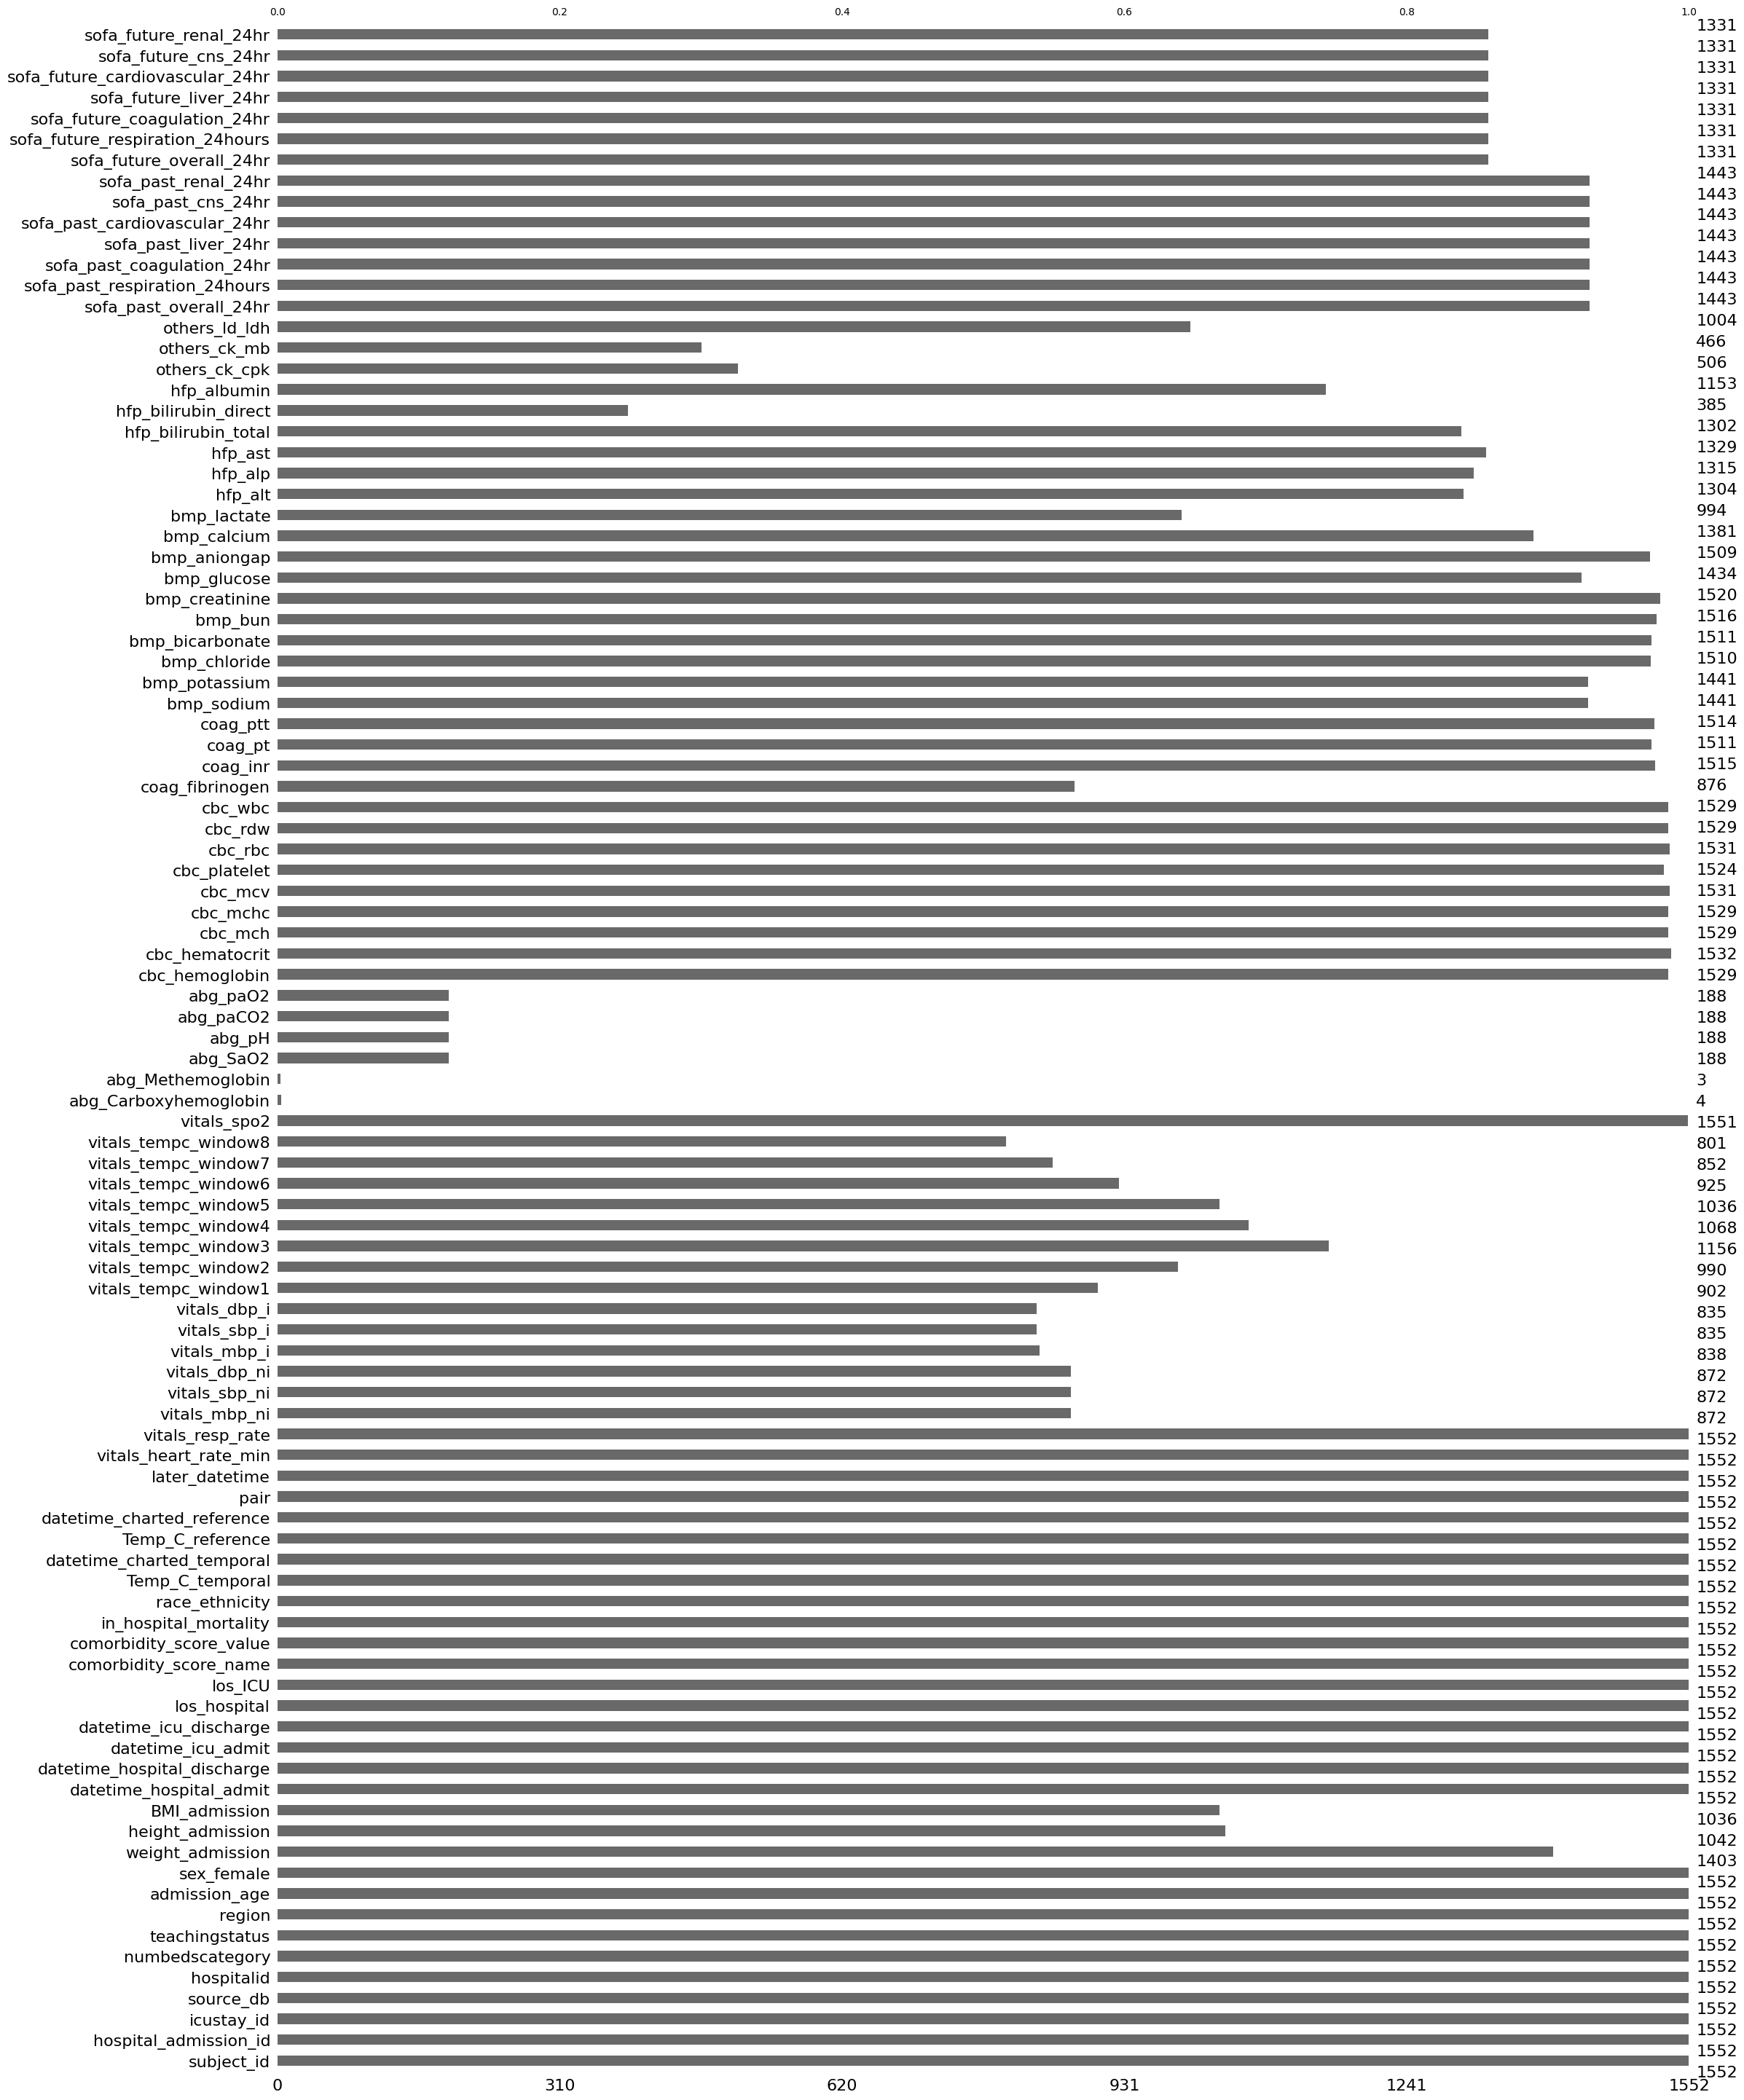

In [309]:
# add missigness plot
mdf = mimiciv_final[[column for column in mimiciv_final.columns if not column.startswith('delta_')]]
msno.bar(mdf)

<Axes: >

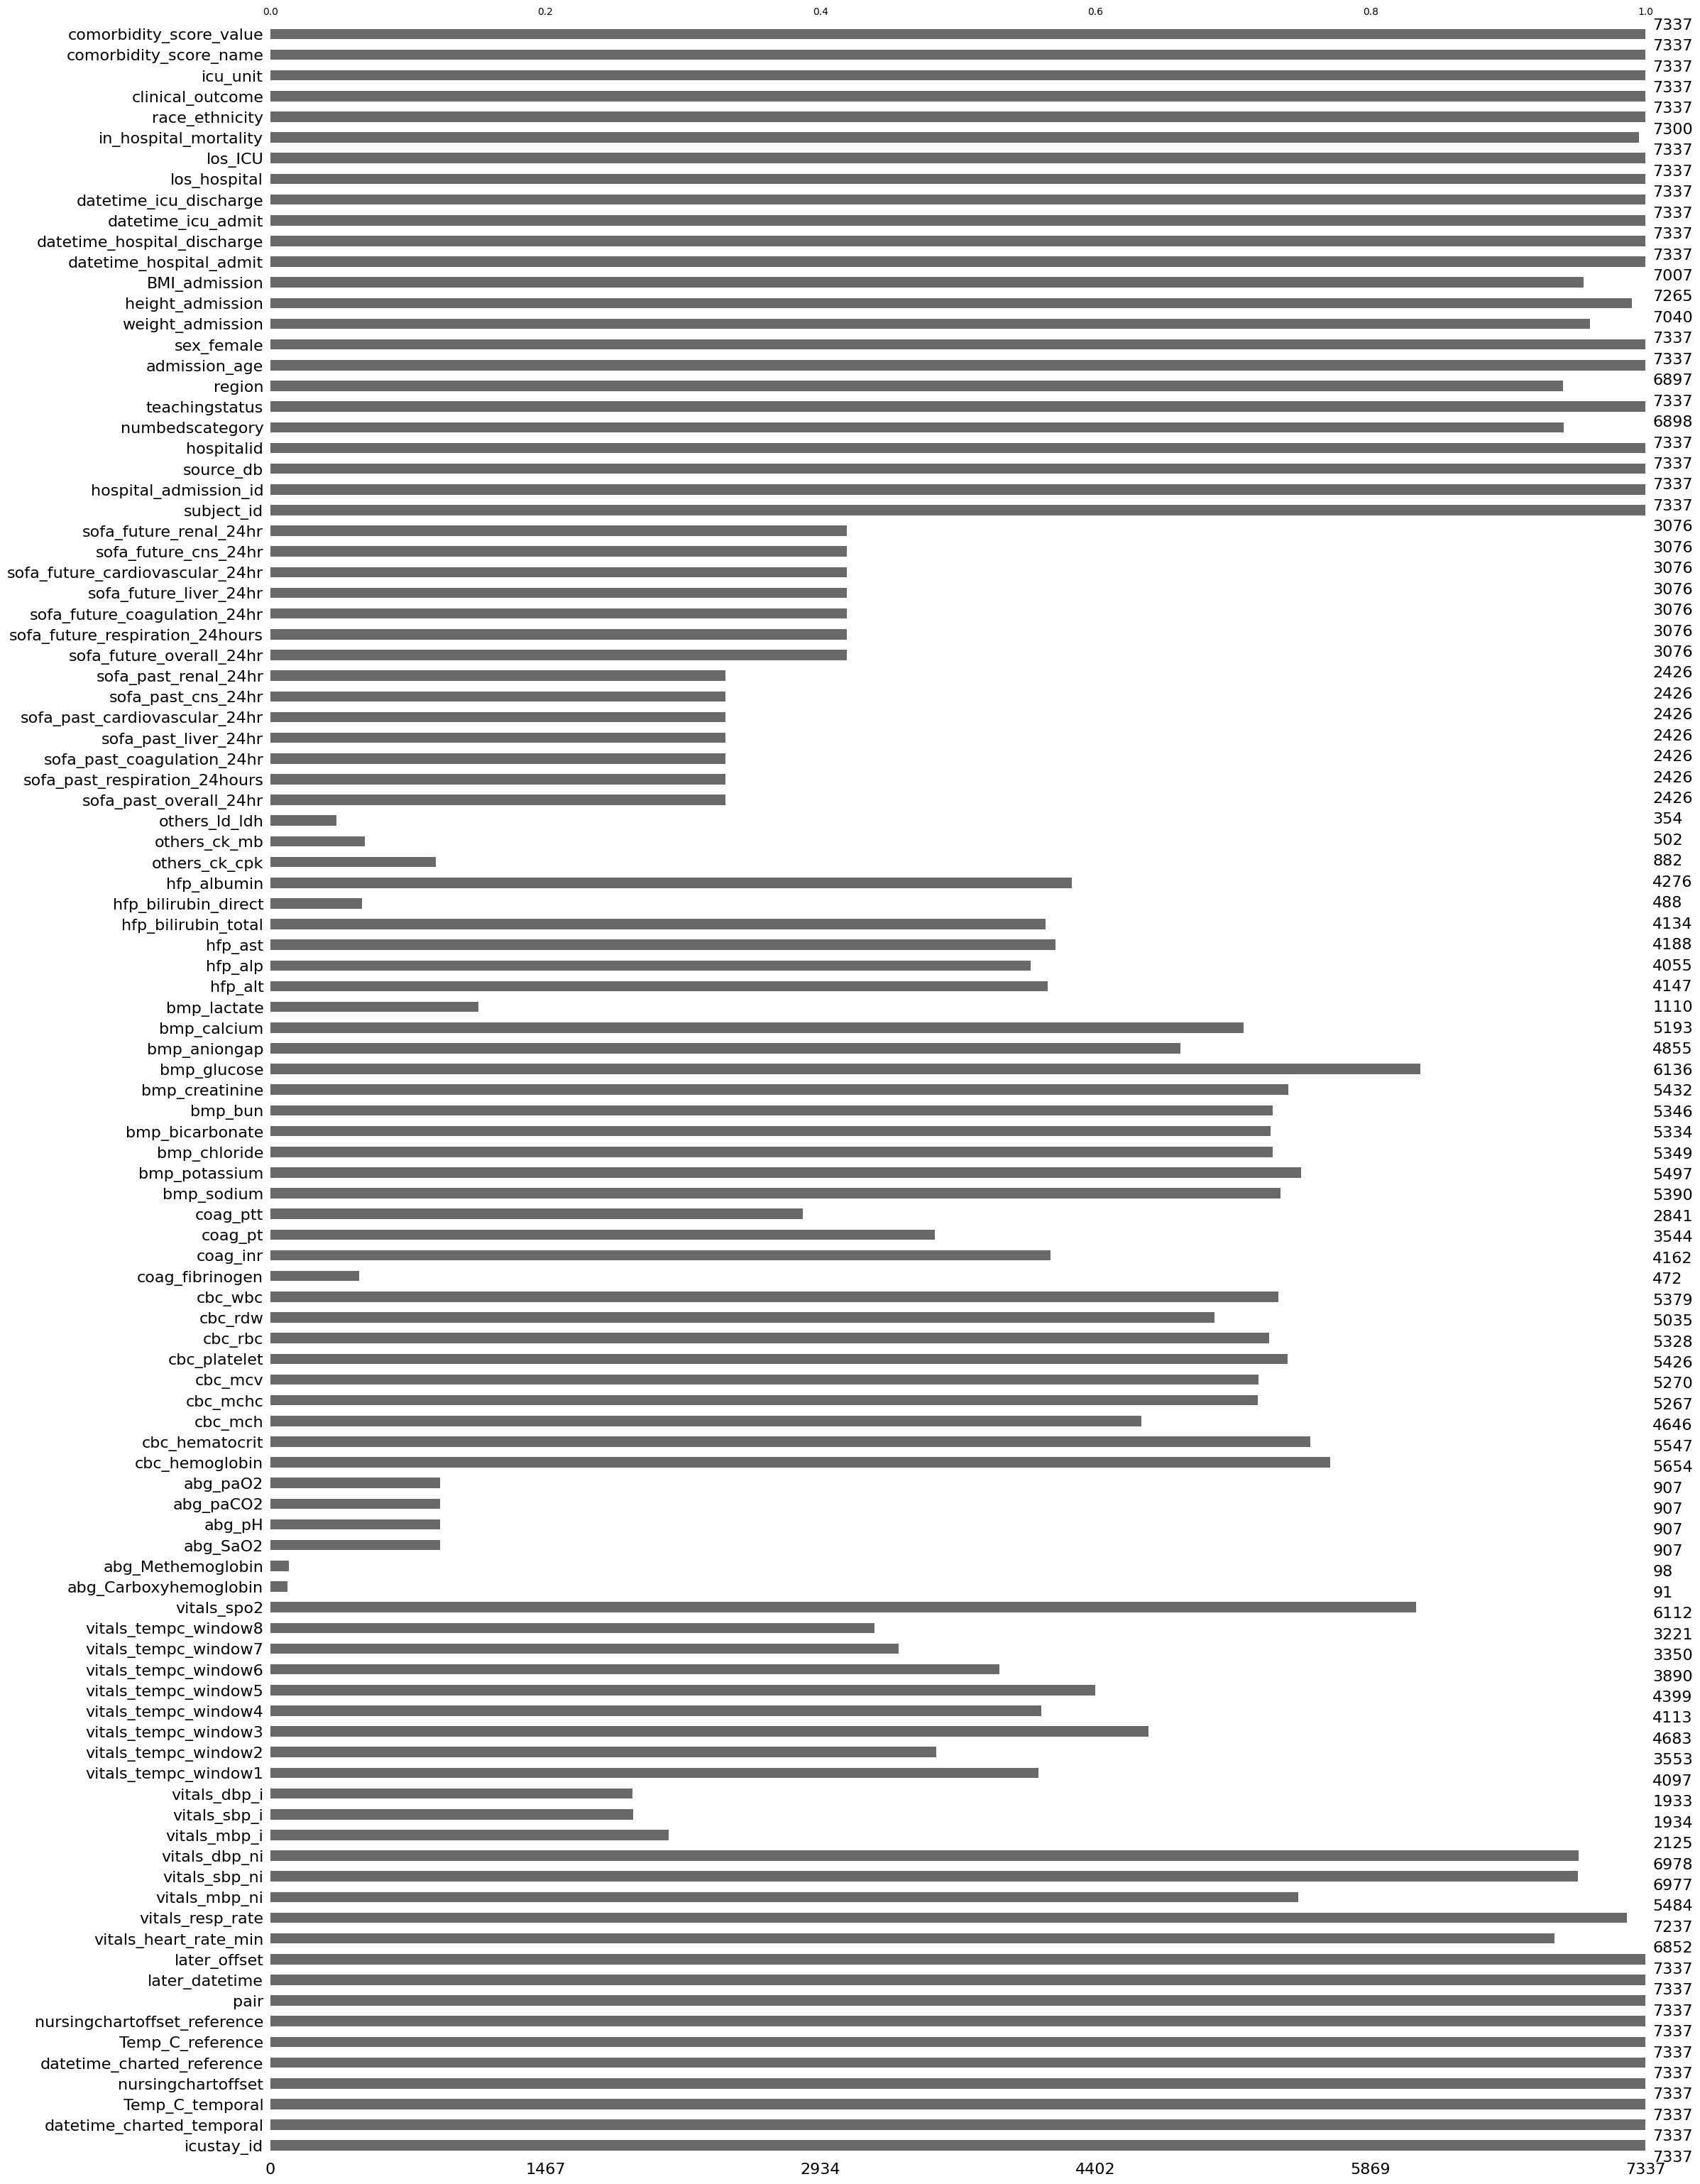

In [310]:
# add missigness plot
mdf = eicu_final[[column for column in eicu_final.columns if not column.startswith('delta_')]]
msno.bar(mdf)

<Axes: >

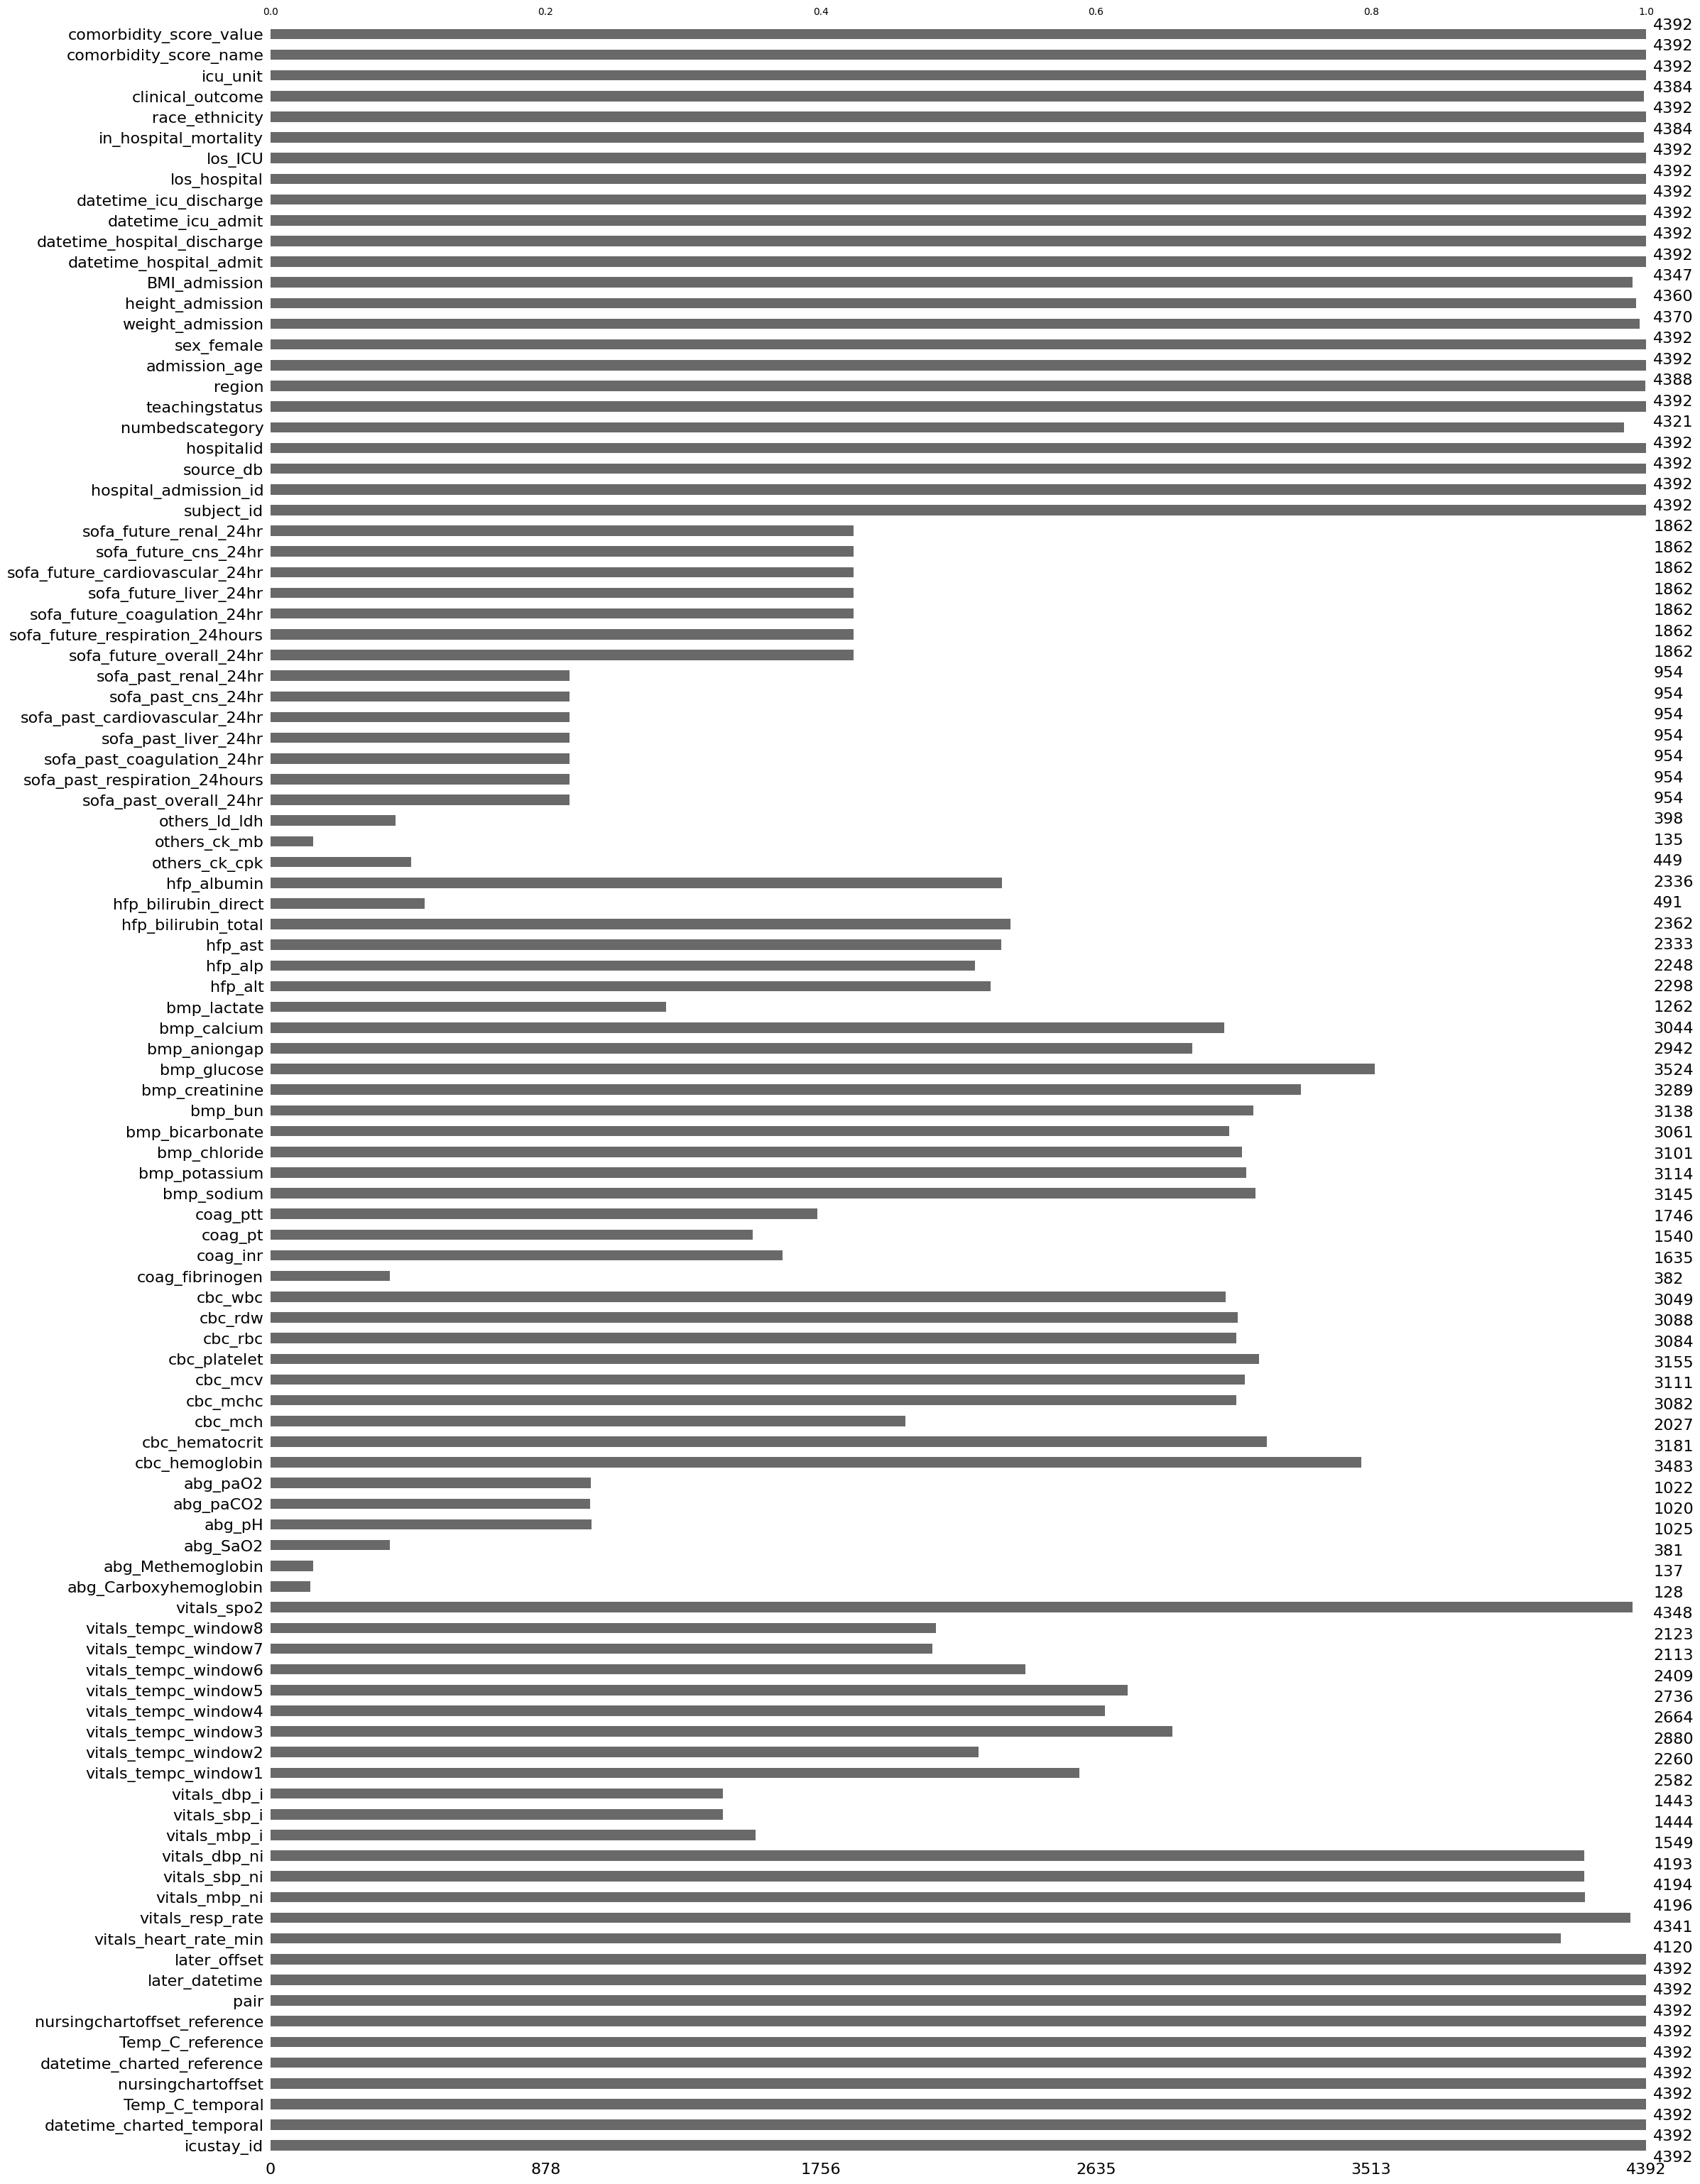

In [311]:
# add missigness plot
mdf = eicu2_final[[column for column in eicu2_final.columns if not column.startswith('delta_')]]
msno.bar(mdf)

In [312]:
columns_to_drop = {'clinical_outcome', 'later_offset', 'icu_unit', 'nursingchartoffset', 'nursingchartoffset_reference'}

# drop the columns
eicu2_final = eicu2_final.drop(columns=columns_to_drop)
eicu_final = eicu_final.drop(columns=columns_to_drop)

In [316]:
# reorder to desired index
# match mimiciv with eicu1 and eicu2
desired_order = [col for col in eicu2_final.columns]
mimiciv_final = mimiciv_final.reindex(columns=desired_order)

In [224]:
# # redo this isn't ideal but just doing this for data quality check
# mimiciv_final = mimiciv_final.sort_index(axis=1)
# eicu2_final = eicu2_final.sort_index(axis=1)
# eicu_final = eicu_final.sort_index(axis=1)

In [317]:
# check all the columns are harmonized
print((eicu_final.columns == eicu2_final.columns).all())
print((mimiciv_final.columns == eicu2_final.columns).all())

True
True


## Merge Vertically

In [318]:
final_df = pd.concat([eicu_final, eicu2_final, mimiciv_final], ignore_index=True)

In [319]:
with pd.option_context('display.max_columns', None, 'display.max_rows',3):
  display(final_df.head(2))
  # sort then reorder columns

icustay_id datetime_charted_temporal  Temp_C_temporal  \
0     3221970 2013-12-31 23:17:00+00:00             36.2   
1     3221970 2013-12-31 23:32:00+00:00             36.4   

  datetime_charted_reference  Temp_C_reference           pair  \
0  2014-01-01 00:17:00+00:00              34.0  temporal-oral   
1  2014-01-01 00:17:00+00:00              34.0  temporal-oral   

             later_datetime  delta_vitals_heart_rate_min  \
0 2014-01-01 00:17:00+00:00                            0   
1 2014-01-01 00:17:00+00:00                            0   

  vitals_heart_rate_min  delta_vitals_resp_rate vitals_resp_rate  \
0                  72.0                       0             16.0   
1                  72.0                       0             16.0   

   delta_vitals_mbp_ni vitals_mbp_ni  delta_vitals_sbp_ni vitals_sbp_ni  \
0                    0          66.0                    0         104.0   
1                    0          66.0                    0         104.0   

   delta_vitals_dbp_ni vitals_dbp_ni  delta_vitals_mbp_i vitals_mbp_i  \
0                    0          55.0                <NA>          NaN   
1                    0          55.0                <NA>          NaN   

   delta_vitals_sbp_i vitals_sbp_i  delta_vitals_dbp_i vitals_dbp_i  \
0                <NA>          NaN                <NA>          NaN   
1                <NA>          NaN                <NA>          NaN   

   delta_vitals_tempc_window1 vitals_tempc_window1  \
0                         -75                 35.8   
1                         -75                 35.8   

   delta_vitals_tempc_window2 vitals_tempc_window2  \
0                        -199                 36.1   
1                        -199                 36.1   

   delta_vitals_tempc_window3 vitals_tempc_window3  \
0                        -472                 36.9   
1                        -472                 36.9   

   delta_vitals_tempc_window4 vitals_tempc_window4  \
0                        <NA>                  NaN   
1                        <NA>                  NaN   

   delta_vitals_tempc_window5 vitals_tempc_window5  \
0                        <NA>                  NaN   
1                        <NA>                  NaN   

   delta_vitals_tempc_window6 vitals_tempc_window6  \
0                        <NA>                  NaN   
1                        <NA>                  NaN   

   delta_vitals_tempc_window7 vitals_tempc_window7  \
0                        <NA>                  NaN   
1                        <NA>                  NaN   

   delta_vitals_tempc_window8 vitals_tempc_window8  delta_vitals_spo2  \
0                        <NA>                  NaN                  0   
1                        <NA>                  NaN                  0   

  vitals_spo2  delta_abg_Carboxyhemoglobin abg_Carboxyhemoglobin  \
0        86.0                         <NA>                   NaN   
1        86.0                         <NA>                   NaN   

   delta_abg_Methemoglobin abg_Methemoglobin  delta_abg_SaO2 abg_SaO2  \
0                     <NA>               NaN            -114     96.7   
1                     <NA>               NaN            -114     96.7   

   delta_abg_pH abg_pH  delta_abg_paCO2 abg_paCO2  delta_abg_paO2 abg_paO2  \
0          -114   7.23             -114      41.0            -114    158.0   
1          -114   7.23             -114      41.0            -114    158.0   

   delta_cbc_hemoglobin  cbc_hemoglobin  delta_cbc_hematocrit  cbc_hematocrit  \
0                  -248            10.2                  <NA>             NaN   
1                  -248            10.2                  <NA>             NaN   

   delta_cbc_mch  cbc_mch  delta_cbc_mchc  cbc_mchc  delta_cbc_mcv  cbc_mcv  \
0           <NA>      NaN            <NA>       NaN           <NA>      NaN   
1           <NA>      NaN            <NA>       NaN           <NA>      NaN   

   delta_cbc_platelet  cbc_platelet  delta_cbc_rbc  cbc_rbc  delta_cbc_rdw  \

In [320]:
def rename_columns(dataframe, column_names_old, column_names_new):
    column_mapping = dict(zip(column_names_old, column_names_new))
    dataframe.rename(columns=column_mapping, inplace=True)

# your first list here
column_names_old = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'height_admission',
    'BMI_admission', 'datetime_hospital_admit', 'datetime_hospital_discharge', 'datetime_icu_admit',
    'datetime_icu_discharge', 'los_hospital', 'los_ICU', 'comorbidity_score_name', 'comorbidity_score_value',
    'in_hospital_mortality', 'race_ethnicity', 'datetime_charted_temporal', 'abg_pH', 'abg_pCO2', 'abg_paO2', 'abg_SaO2',
    'abg_Carboxyhemoglobin', 'abg_Methemoglobin', 'datetime_charted_reference', 'vitals_heart_rate', 'vitals_resp_rate',
    'vitals_mbp_ni', 'vitals_sbp_ni', 'vitals_dbp_ni', 'vitals_mbp_i', 'vitals_sbp_i', 'vitals_dbp_i',
    'vitals_tspo2', 'cbc_hemoglobin', 'cbc_hematocrit', 'cbc_mch', 'cbc_mchc', 'cbc_mcv', 'cbc_platelet',
    'cbc_rbc', 'cbc_rdw', 'cbc_wbc', 'coag_fibrinogen', 'coag_inr', 'coag_pt', 'coag_ptt', 'bmp_sodium',
    'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine', 'bmp_glucose',
    'bmp_aniongap', 'bmp_calcium', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total',
    'hfp_bilirubin_direct', 'hfp_albumin', 'others_ck_cpk', 'others_ck_mb', 'others_ld_ldh',
    'sofa_past_overall_24hr', 'sofa_past_coagulation_24hr',
    'sofa_past_liver_24hr', 'sofa_past_cardiovascular_24hr', 'sofa_past_cns_24hr', 'sofa_past_renal_24hr',
    'sofa_future_overall_24hr', 'sofa_future_coagulation_24hr', 'sofa_future_liver_24hr',
    'sofa_future_cardiovascular_24hr', 'sofa_future_cns_24hr', 'sofa_future_renal_24hr',
    'vitals_tempc_window1', 'vitals_tempc_window8'
]

# your second list here
# charlson score is fine, no need to split
# replace spo2 and sao2 with correct temps
# temp_c should be vitals spo2
column_names_new = [
    'Subject ID', 'Hospital Admission ID', 'ICU Stay ID', 'Source Database', 'Hospital ID', 'Number of Beds Category',
    'Teaching Status', 'US Census Region', 'Admission Age', 'Female Sex', 'Admission Weight', 'Admission Height',
    'Admission BMI', 'Datetime of Hospital Admission', 'Datetime of Hospital Discharge', 'Datetime of ICU Admission',
    'Datetime of ICU Discharge', 'LOS Hospital', 'LOS ICU', 'Comorbidity Score Name', 'Comorbidity Score (Charlson/Elixhauser)',
    'In-Hospital Mortality', 'Race-Ethnicity', 'Temporal Timestamp', 'ABG pH', 'ABG pCO2', 'ABG paO2', 'ABG SaO2',
    'Carboxyhemoglobin', 'Methemoglobin', 'Reference Timestamp', 'Vitals Heart Rate', 'Vitals Resp Rate',
    'Vitals niMBP', 'Vitals niSBP', 'Vitals niDBP', 'Vitals iMBP', 'Vitals iSBP', 'Vitals iDBP',
    'Vitals SpO2', 'CBC Hemoglobin', 'CBC Hematocrit', 'CBC MCH', 'CBC MCHC', 'CBC MCV', 'CBC Platelets',
    'CBC RBC', 'CBC RDW', 'CBC WBC', 'Coagulation Fibrinogen', 'Coagulation INR', 'Coagulation PT', 'Coagulation PTT', 'Sodium',
    'Potassium', 'Chloride', 'Bicarbonate', 'Blood Urea Nitrogen', 'Creatinine', 'Glucose',
    'Anion-gap', 'Calcium', 'Lactate', 'Alanine Transaminase', 'Alkaline Phosphatase', 'Aspartate Transaminase', 'Bilirubin Total',
    'Bilirubin Direct', 'Albumin', 'Creatine Kinase', 'Creatine Kinase MB', 'Lactate Dehydrogenase',
    'SOFA Past Overall 24hr', 'SOFA Past Coagulation 24hr',
    'SOFA Past Liver 24hr', 'SOFA Past Cardiovascular 24hr', 'SOFA Past CNS 24hr', 'SOFA Past Renal 24hr',
    'SOFA Future Overall 24hr', 'SOFA Future Coagulation 24hr', 'SOFA Future Liver 24hr',
    'SOFA Future Cardiovascular 24hr', 'SOFA Future CNS 24hr', 'SOFA Future Renal 24hr',
    'Tempertature First Past Window', 'Tempertature Last Past Window'
]

# define columns of interest, talk about columns retained in questions later
# spo2, sao2
# temperature windows (first and last)
columns_retained = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'datetime_hospital_admit',
    'datetime_hospital_discharge', 'datetime_icu_admit', 'datetime_icu_discharge', 'los_hospital', 'los_ICU',
    'comorbidity_score_name', 'comorbidity_score_value', 'in_hospital_mortality', 'race_ethnicity', 'datetime_charted_temporal',
    'abg_Carboxyhemoglobin', 'abg_Methemoglobin', 'datetime_charted_reference', 'cbc_hemoglobin', 'coag_fibrinogen', 'coag_inr', 'coag_pt',
    'coag_ptt', 'bmp_sodium', 'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine',
    'bmp_glucose', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total', 'hfp_albumin',
    'others_ck_cpk', 'sofa_past_overall_24hr', 'sofa_future_overall_24hr',
    'vitals_tempc_window1', 'vitals_tempc_window8'
]

In [321]:
existing_variables = [col for col in columns_retained if col in column_names_old]
missing_variables = [col for col in columns_retained if col not in column_names_old]

missing_variables

[]

In [322]:
# delta
# using temporal offest for the time varying covariate pull
# should I redo the patient characteristcs to match the spreadsheet
# charlson score
# hemoglobin variable abg, ask

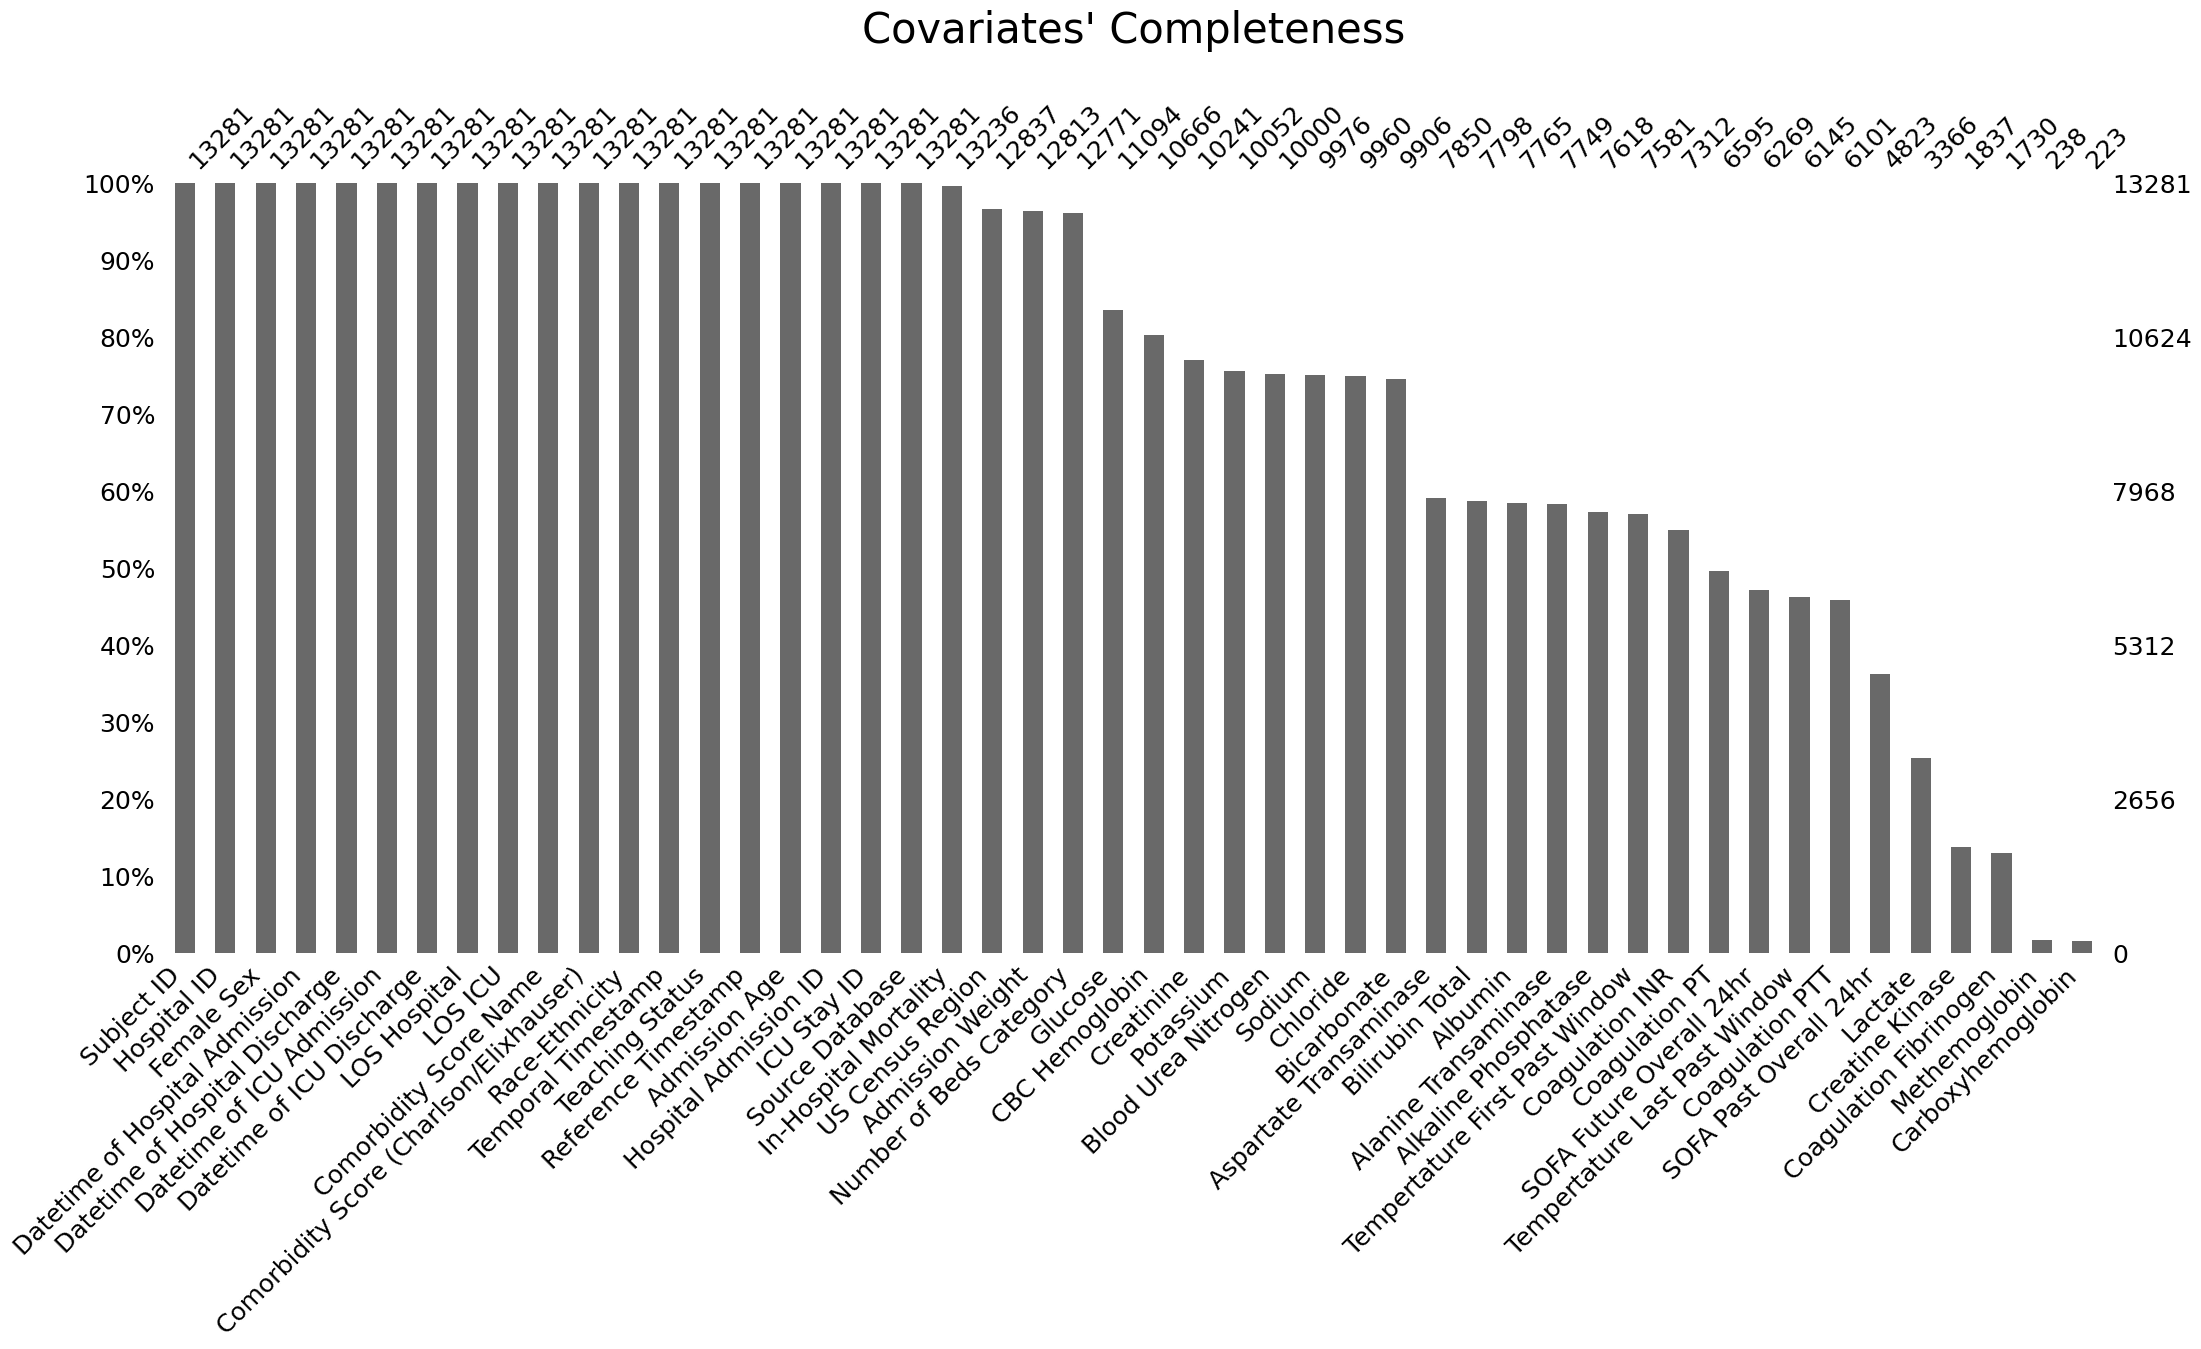

In [323]:
mdf = final_df[[column for column in final_df.columns if not column.startswith('delta_')]]

# Retain only columns of interest
mdf = mdf[columns_retained]

# Call the function to rename the columns
rename_columns(mdf, column_names_old, column_names_new)

# Plot Missingness Bar Chart

mdf_sorted = msno.nullity_sort(mdf, sort='descending') # or sort='ascending'
bar = msno.bar(mdf_sorted, filter='top', sort='descending', fontsize = 18,  label_rotation=45)

#bar.axes[0].tick_params(axis='y', labelsize=30)

# Modify y-axis labels to percentages
plt.yticks(np.arange(0, 1.1, 0.1), [str(int(x * 100)) + '%' for x in np.arange(0, 1.1, 0.1)])
plt.title("Covariates' Completeness\n", fontsize=30)
plt.show()

In [ ]:
# mimic4 has less pairs then eicu or eicu2
# different number based on paper
# discuss ian's question for data quality check
# mimic3? but not temporal
# vitals temp different windows discussion
# add other variables to covariates completeness?
# other notebooks?

# most patients temp captured before going into icu
# pair chartime - admission offset to justify past vs future
# discharge offset - paircharttime < 24 hours

In [334]:
# eicu2_final["datetime_icu_discharge"].tz_localize('UTC') - eicu2_final["later_datetime"]
# eicu2_final['datetime_icu_discharge'] = pd.to_datetime(eicu2_final['datetime_icu_discharge']).dt.tz_localize('UTC')
eicu2_final['datetime_icu_discharge'] - eicu2_final["later_datetime"]

0        0 days 11:25:00
1        0 days 11:23:00
2        3 days 16:14:00
3        7 days 06:58:00
4        7 days 06:58:00
              ...       
4387     0 days 23:24:00
4388     8 days 10:46:00
4389     0 days 18:46:00
4390   -3 days +04:58:00
4391   -3 days +19:26:00
Length: 4392, dtype: timedelta64[ns]

In [343]:
eicu2_final['time_difference'] =  eicu2_final['datetime_icu_discharge'] - eicu2_final['later_datetime']

less_than_1_day = eicu2_final['time_difference']  < pd.Timedelta(days=1)

count_less_than_1_day = less_than_1_day.sum()
count_less_than_1_day

2098

In [340]:
#eicu_final['datetime_icu_discharge'] = pd.to_datetime(eicu_final['datetime_icu_discharge']).dt.tz_localize('UTC')
eicu_final['time_difference'] =  eicu_final['datetime_icu_discharge'] - eicu_final['later_datetime']
less_than_1_day = eicu_final['time_difference']  < pd.Timedelta(days=1)

count_less_than_1_day = less_than_1_day.sum()
count_less_than_1_day


3684

In [345]:
# mimiciv_final['datetime_icu_discharge'] = pd.to_datetime(mimiciv_final['datetime_icu_discharge']).dt.tz_localize('UTC')
mimiciv_final['time_difference'] =  mimiciv_final['datetime_icu_discharge'] - mimiciv_final['later_datetime']
less_than_1_day = mimiciv_final['time_difference']  >  pd.Timedelta(days=1)

count_less_than_1_day = less_than_1_day.sum()
count_less_than_1_day

1353